In [1]:
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(ggplot2)))
library(repr)
library(scales)
options(repr.plot.width=15, repr.plot.height=10)

In [2]:
listGeuvadis = read.table('../data/01_raw/SampleTot.txt',header = T)
hlaExp = read.table("../data/01_raw/hla_expression.tsv", sep = "\t", header = T) %>% mutate(subject_id = as.character(subject_id)) %>% filter(subject_id %in% listGeuvadis$subject_id)
hlaExp %>% head(3)

,subject_id,pop,sex,lab,gene_name,tpm
,<chr>,<fct>,<fct>,<fct>,<fct>,<dbl>
1,HG00096,GBR,male,UNIGE,HLA-A,1604.34
2,HG00096,GBR,male,UNIGE,HLA-B,2987.70
3,HG00096,GBR,male,UNIGE,HLA-C,1087.53


# General gene expression distributions

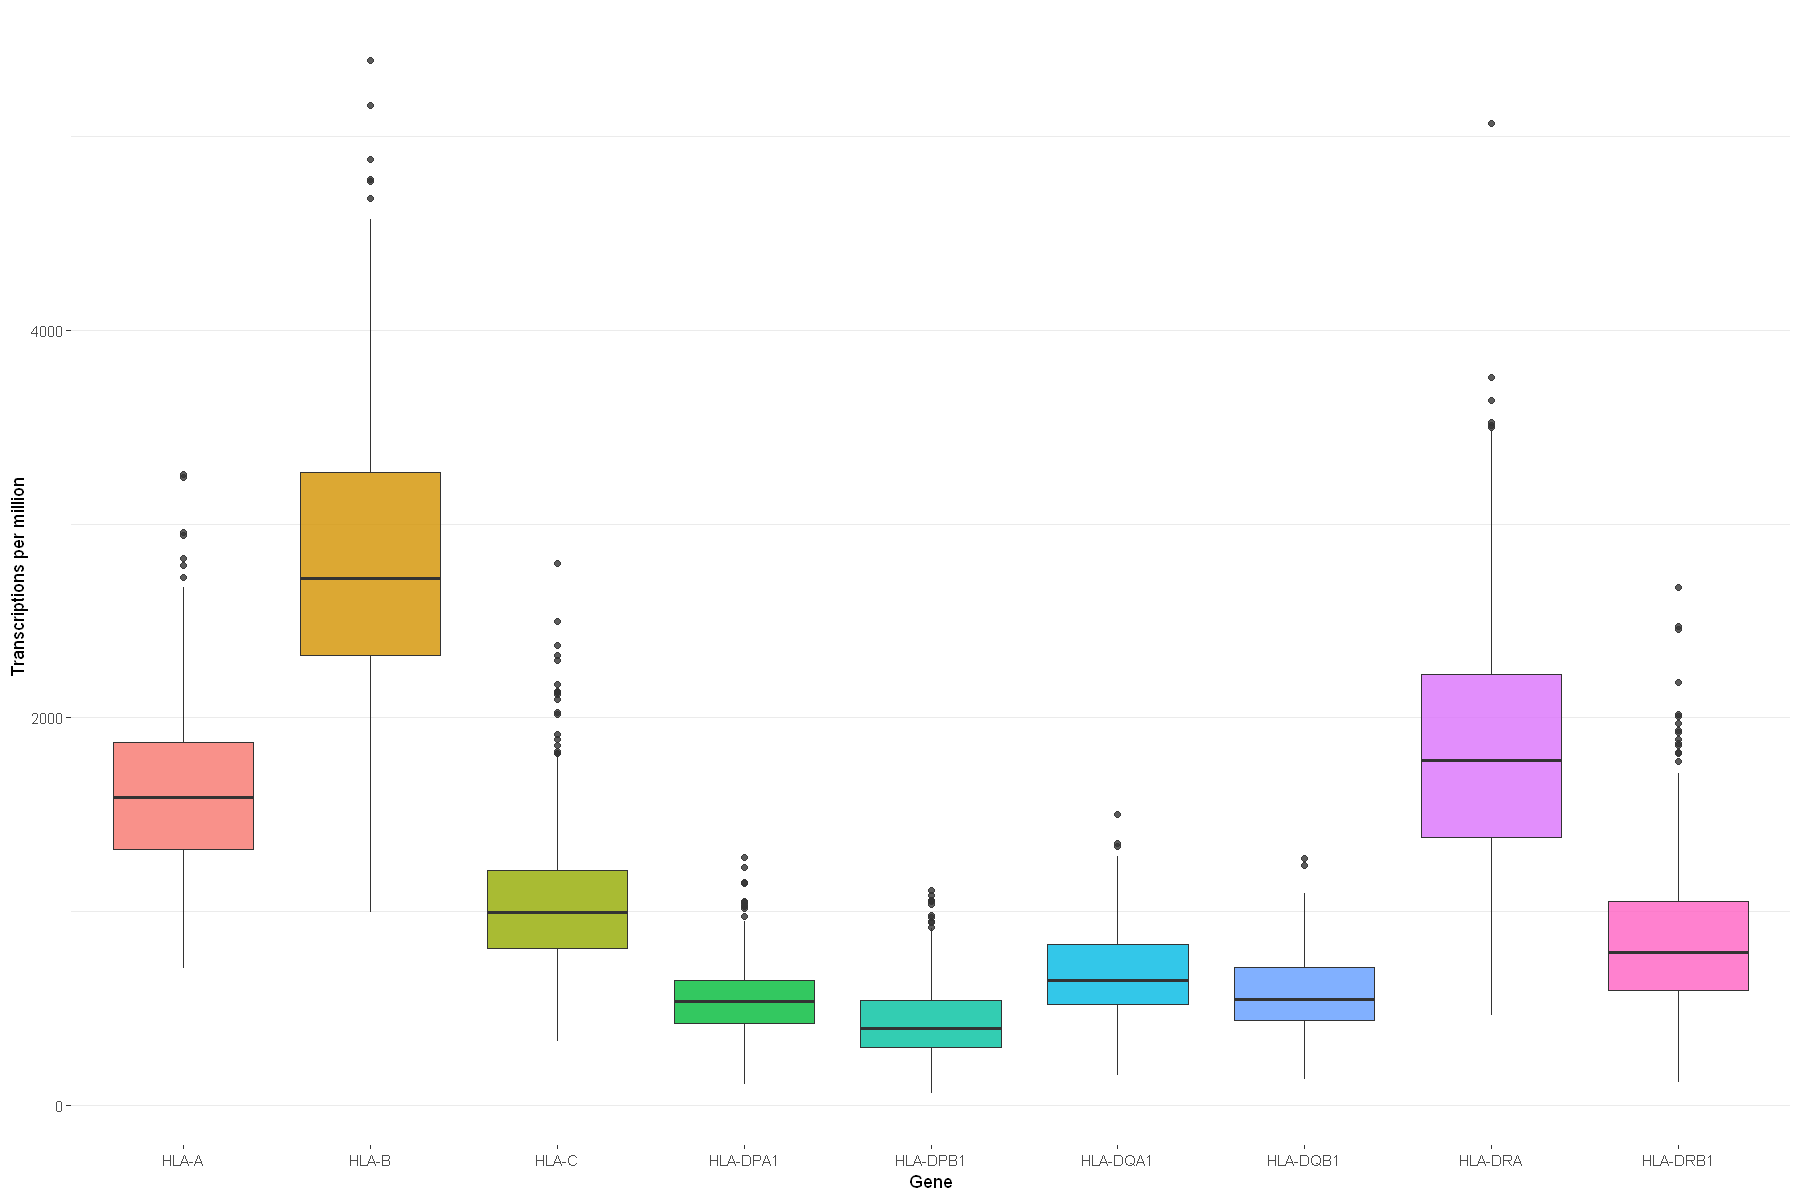

In [3]:
boxplotGenes = hlaExp %>% ggplot(aes(x = gene_name , y=tpm , fill = gene_name)) +
geom_boxplot(alpha = .8) +
theme_bw() +
theme( 
      legend.position='none',
      panel.border = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
labs(x = 'Gene',y= "Transcriptions per million" , fill = 'Gene')
boxplotGenes

# Symmetry plot

In [4]:
# List of all unique genes of interest
genesLoop = sort(unique(hlaExp$gene_name))
# Creating data frame to plot assymetry
dfSymmetryPhen = as.data.frame(NULL)
dfGreatesValues = as.data.frame(1:5)
idsHigher = c()

for( idx_ in 1:length(genesLoop) ){
    # For each gene:
    gene_ = genesLoop[idx_]
    # Filter gene associated information
    aux = hlaExp %>% filter(gene_name == gene_)
    # Selecting samples in top 10 tpm
    top10 = aux %>% arrange(-tpm) %>% mutate(n = 1:n()) %>% filter(n <= 10) %>% select(c('subject_id','tpm'))
    idsHigher = c(idsHigher,top10$subject_id)
    colnames(top10) = c(paste0(gene_,'_sample') , paste0(gene_,'_tpm'))
    dfGreatesValues = cbind(dfGreatesValues,top10)
    # Sort in ascending order gene expression (tpm)
    tpmSort = sort(aux$tpm)
    # Separate ordered set in two parts:
    # the 50% lower values - valuesInf
    #  and the 50% greater values - valuesSup
    # Then measure the distance to the median
    lengthSamp = length(tpmSort)
    sizeParts = round(lengthSamp/2)
    valuesInf = quantile(aux$tpm,.5) - tpmSort[1:sizeParts]
    valuesSup = tpmSort[seq(from = lengthSamp , to = (lengthSamp - sizeParts + 1))] - quantile(aux$tpm,.5)
    # create auxiliary df to append info
    dfAppend = as.data.frame(valuesInf)
    dfAppend$Sup_ = valuesSup
    dfAppend$gene_ = gene_
    # Append in final df
    dfSymmetryPhen = rbind(dfSymmetryPhen , dfAppend)
}
colnames(dfSymmetryPhen)[1] = 'Inf_'


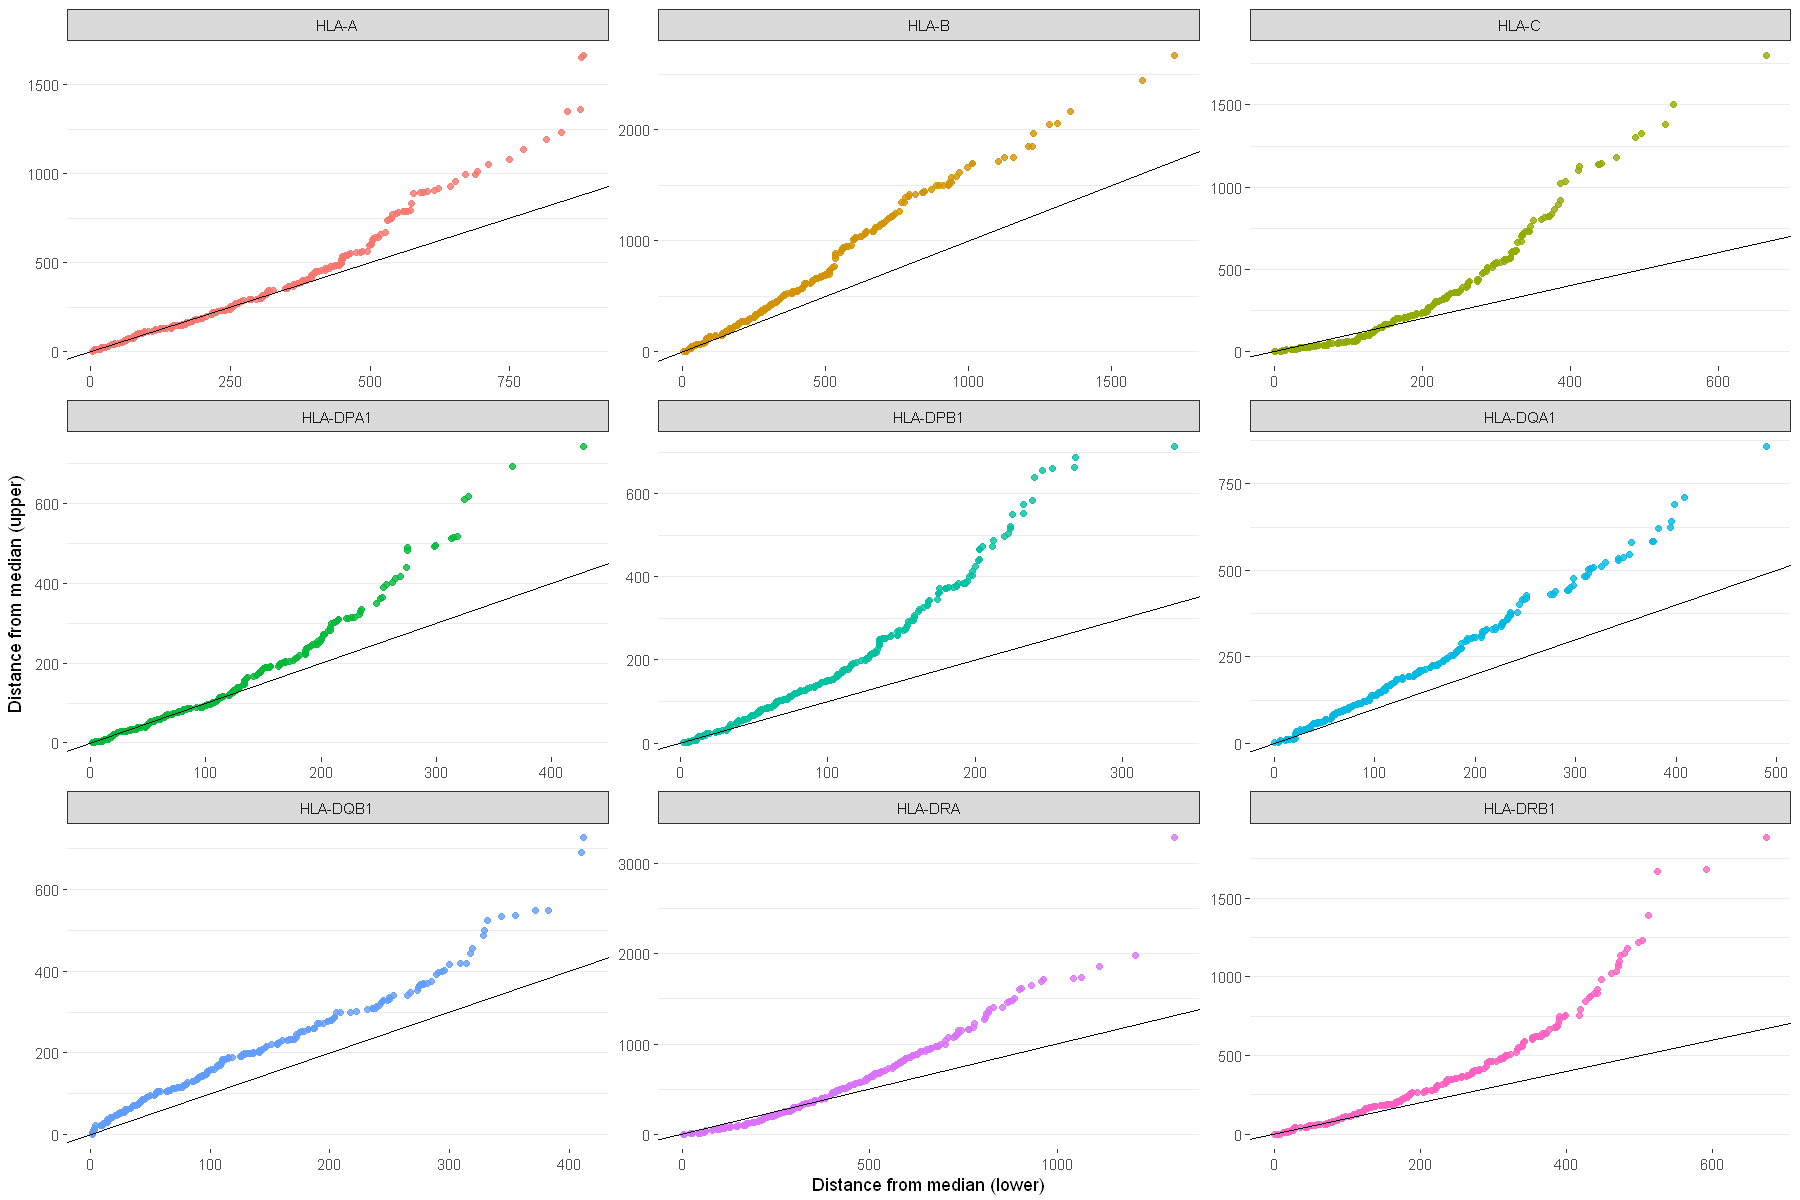

In [5]:
# Plot assymetry
plotSymmetry = dfSymmetryPhen %>% ggplot(aes(x = Inf_ , y = Sup_ , colour = gene_)) +
geom_point(alpha = .8) +
geom_abline(intercept = 0 , slope = 1) +
theme_bw() +
theme( 
      legend.position='none',
      panel.border = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
facet_wrap(~gene_ , scales = 'free')+
labs(x = "Distance from median (lower)" , y= 'Distance from median (upper)' , colour = 'Gene')
plotSymmetry

# Possible outliers (Multivariate)

In [6]:
confidenceBandsMahalanobis = function(n,qtTrials = 1000,idxInf = 25 , idxSup = 975){

    sample_ = matrix(0,n,qtTrials)
    limInf = numeric(n)
    limSup = numeric(n)
    #
    set.seed(9297791)
    for(i in 1:qtTrials){
        sample_[,i] = rchisq(n,df = 9)
        sample_[,i] = sort(sample_[,i]) 
        }
    #
    for(i in 1:n){
        quantiles_ = sort(sample_[i,])
        limInf[i]  = quantiles_[idxInf]
        limSup[i]  = quantiles_[idxSup]
        
        }
    return(list(limInf,limSup))
}

dfMahalanobis = function(horizontalExpDf,prob_=.993,df_=8){

    # Filter columns of interest - gene expressions and samples
    horizontalTpm = horizontalExpDf[,grepl('HLA|subject',colnames(horizontalExpDf))] 

    # Calculate means and covariance matrix
    meanExp = colMeans(horizontalTpm[,2:10])
    covExp = cov(horizontalTpm[,2:10])
    # Calculate Mahalanobis distance
    mahalanobisD = mahalanobis(horizontalTpm[,2:10],center = meanExp,cov = covExp)
    horizontalExpDf$Mahalanobis = mahalanobisD
    horizontalExpDf$idx = 1:nrow(horizontalExpDf)
    # Defining threshold on 99.9% chi-squared (9 df) quantile 
    cutMahalanobis = qchisq(prob_, df = df_)
    # Create dummy variable to define colours in the plot
    horizontalExpDf = horizontalExpDf %>% mutate(threshold = ifelse(Mahalanobis > cutMahalanobis , 'yes' , 'no'))

    return(horizontalExpDf)

}

plotMahalanobis = function(horizontalExpDf,prob_=.993,df_=8){

    cutMahalanobis = qchisq(prob_, df = df_)
    # Plot Mahalanobis Distance by index
    plotMahalanobis = horizontalExpDf %>% 
    ggplot(aes(x = idx , y = Mahalanobis , colour =  threshold)) +
    geom_point() +
    geom_hline(yintercept=cutMahalanobis) +
    ggrepel::geom_text_repel(data=subset(horizontalExpDf, Mahalanobis > cutMahalanobis), max.overlaps = 50,
                aes(idx,Mahalanobis,label=subject_id)) +
    theme_bw() +
    theme( 
        legend.position='none',
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank()
        )

    return(plotMahalanobis)

}
# ggsave(paste0(rootSave,'mahalanobis',".png"), plotMahalanobis, bg = "transparent",width=10, height=8, dpi=300)

plotMahalanobisQQ = function(horizontalExpDf,prob_=.993,df_=9){

    cutMahalanobis = qchisq(prob_, df = df_)
    # Sorting Mahalanobis values
    dfOrderedMahalanobis = as.data.frame( sort ( horizontalExpDf$Mahalanobis) )
    # Defining quantile values to compare with Chi-squared distribution
    dfOrderedMahalanobis$idx = ((1:nrow(dfOrderedMahalanobis)) - .5)/nrow(dfOrderedMahalanobis)
    dfOrderedMahalanobis$chisqQ = qchisq(dfOrderedMahalanobis$idx, df = df_)
    # Selecting only observed mahalanobis and expected chi-squared value
    dfOrderedMahalanobisPlt = dfOrderedMahalanobis[,c(1,3)]
    colnames(dfOrderedMahalanobisPlt) = c('Observed','Expected')
    # Label high values
    dfOrderedMahalanobisPlt = dfOrderedMahalanobisPlt %>% mutate(Threshold = ifelse(Observed > cutMahalanobis , 'yes' , 'no'))

    # Creating confidence bands
    intervalFull = confidenceBandsMahalanobis(n = nrow(dfOrderedMahalanobisPlt) , idxInf = 50 , idxSup = 9950 , qtTrials = 10000)
    dfOrderedMahalanobisPlt$LimInf = intervalFull[[1]]
    dfOrderedMahalanobisPlt$LimSup = intervalFull[[2]]

    # Quantile-quantile plot - comparing Mahalanobis distance with Chi-squared distribution
    plotQQFull = dfOrderedMahalanobisPlt %>% 
    ggplot() +
    geom_point( aes ( x = Expected , y = Observed , colour = Threshold) ) +
    geom_line ( aes ( x = Expected , y = LimInf ) , linetype = 2 , colour = 'red' ) +
    geom_line ( aes ( x = Expected , y = LimSup ) , linetype = 2 , colour = 'red' ) +
    geom_abline( slope = 1 , intercept = 0 ) +
    theme_bw() +
    theme( 
        legend.position='none',
        panel.border = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank()
        ) 

    return(plotQQFull)
    
}

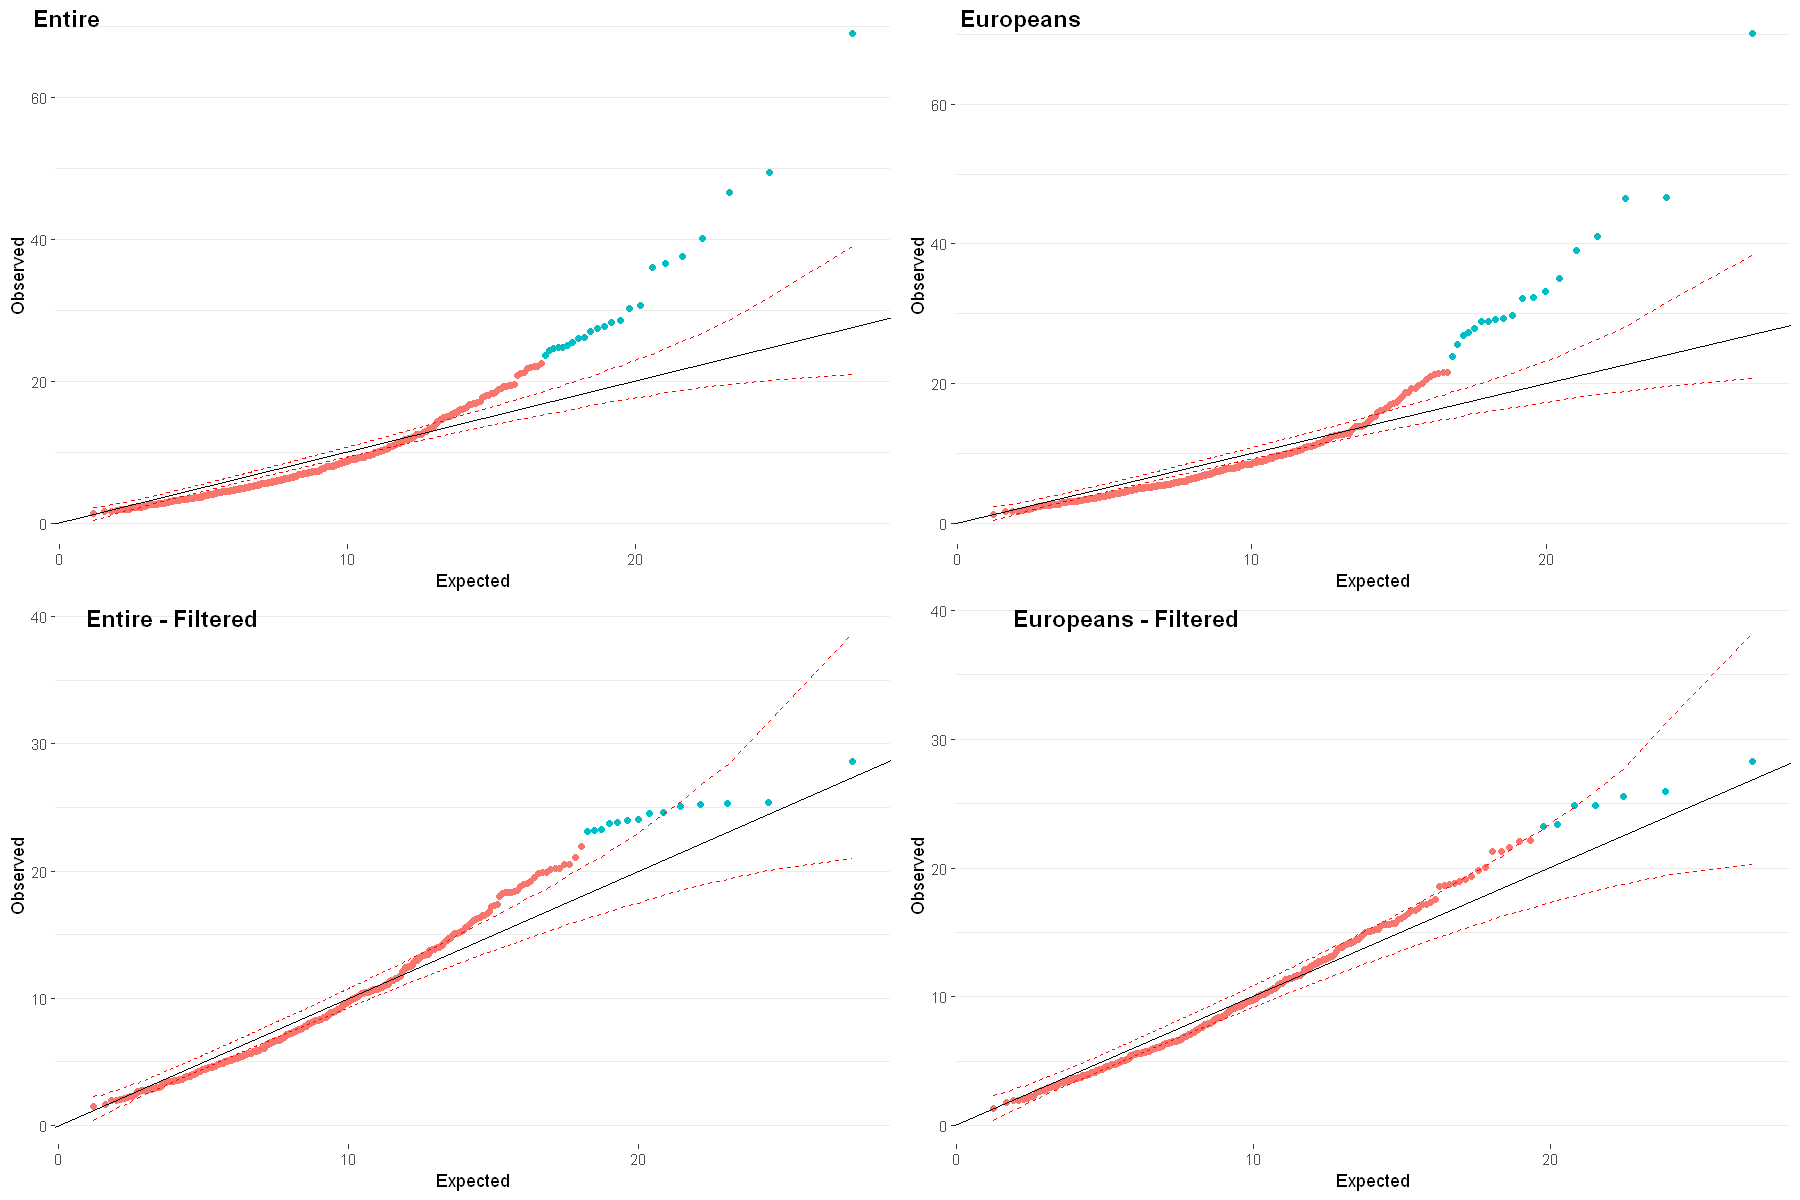

In [7]:
# Transforming original dataset in horizontal position to analyse
dfMahalanobisAnalysis = tidyr::spread(hlaExp,gene_name,tpm)
dfMahalanobisEurAnalysis = tidyr::spread(hlaExp,gene_name,tpm) %>% filter(pop != 'YRI')
# Mahalanobis with all available data
dfMahalanobisFull = dfMahalanobis(dfMahalanobisAnalysis)
# Mahalanobis, excluding possible outliers
dfMahalanobisOut = dfMahalanobis(dfMahalanobisFull %>% filter(threshold == 'no'))
# Mahalanobis with only europeans
dfMahalanobisEur = dfMahalanobis(dfMahalanobisEurAnalysis)
# Mahalanobis with only europeans, excluding possible outliers
dfMahalanobisEurOut = dfMahalanobis(dfMahalanobisEur %>% filter(threshold == 'no'))

p11 = plotMahalanobisQQ(dfMahalanobisFull)
p12 = plotMahalanobisQQ(dfMahalanobisEur)
p21 = plotMahalanobisQQ(dfMahalanobisOut)
p22 = plotMahalanobisQQ(dfMahalanobisEurOut)

pltMahalanobis = ggpubr::ggarrange( 
                    p11, p12, p21 , p22 ,
                    labels = c("Entire", "Europeans",'Entire - Filtered','Europeans - Filtered'),
                    ncol = 2, nrow = 2
                    )
pltMahalanobis

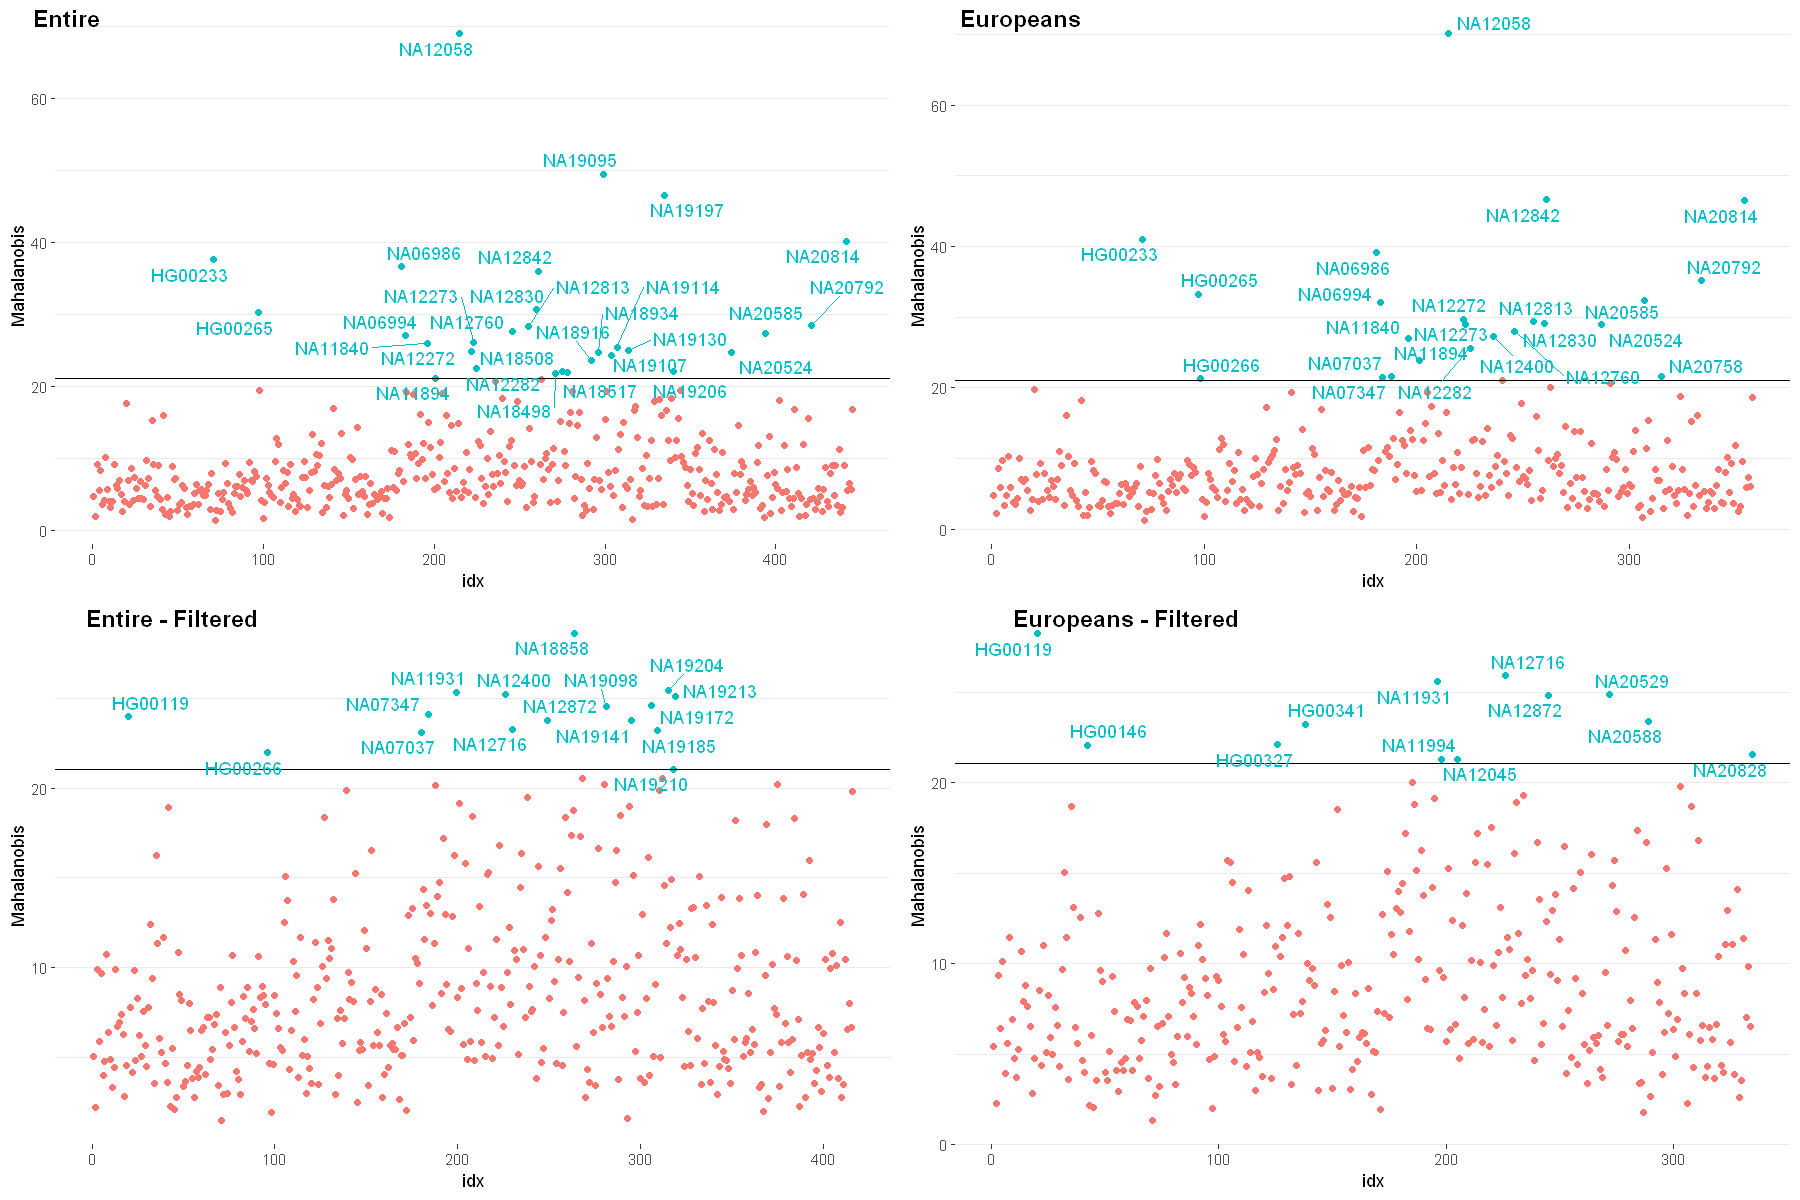

In [8]:
p11 = plotMahalanobis(dfMahalanobisFull)
p12 = plotMahalanobis(dfMahalanobisEur)
p21 = plotMahalanobis(dfMahalanobisOut)
p22 = plotMahalanobis(dfMahalanobisEurOut)

pltMahalanobis = ggpubr::ggarrange( 
                    p11, p12, p21 , p22 ,
                    labels = c("Entire", "Europeans",'Entire - Filtered','Europeans - Filtered'),
                    ncol = 2, nrow = 2
                    )
pltMahalanobis

# Biplot

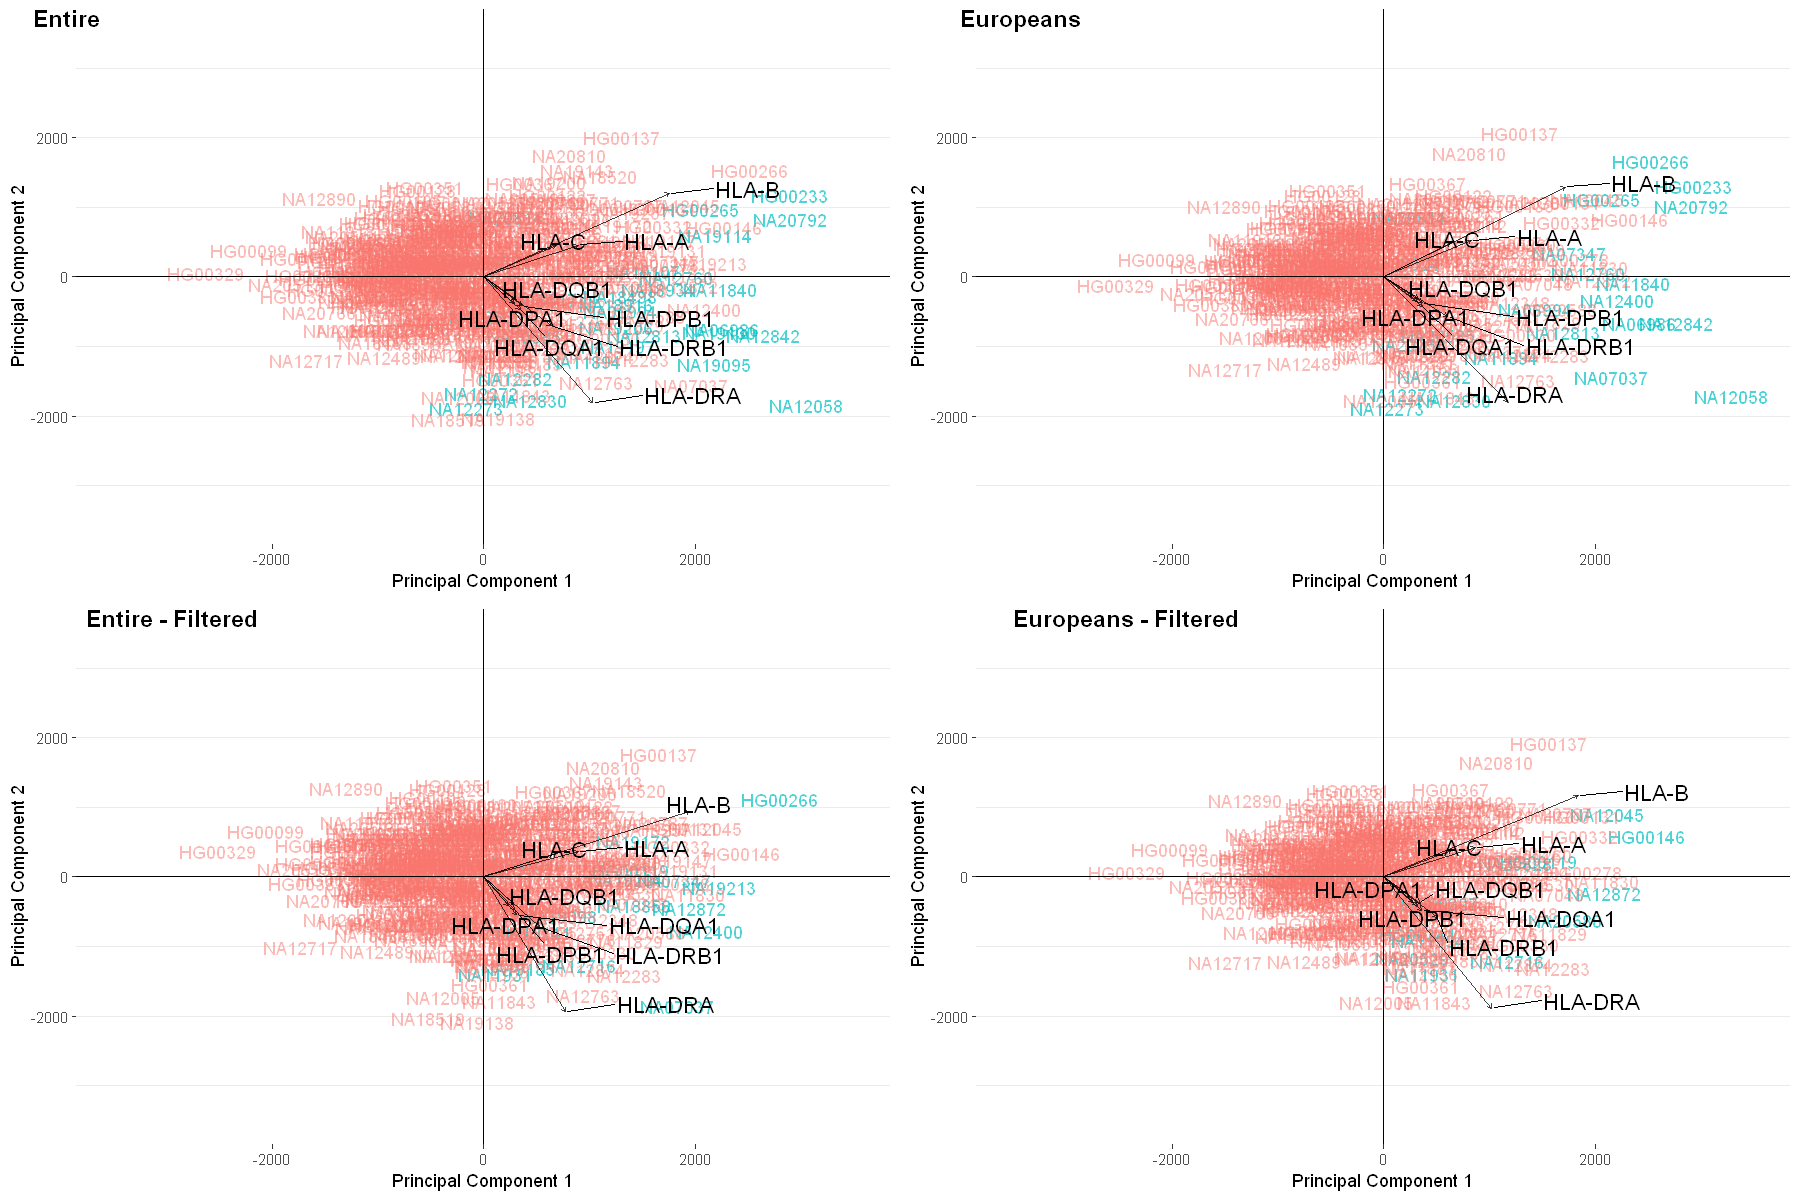

In [9]:
biplotPlt = function( dfCovars_, sample_, cor_, dfThreshold_, scaleBip_ , limit_) {

    biplotFit = princomp(x = dfCovars_, cor = cor_)
    biplotDf = data.frame(subject_id = sample_ , biplotFit$scores)
    biplotDf = biplotDf %>% mutate(subject_id = as.character(subject_id))
    # Merge df with dummy variable based on Mahalanobis distance and threshold
    biplotDf = merge(biplotDf,dfThreshold_)
    pcLoads = data.frame(biplotFit$loadings[,1:2])
    
    plotBiplot = biplotDf %>% ggplot() + 
        geom_text(data=subset(biplotDf, threshold == 'yes'),
                    aes(Comp.1,Comp.2,label=subject_id,colour = threshold),alpha = .7) +
        geom_text(data=subset(biplotDf, threshold == 'no'),
                    aes(Comp.1,Comp.2,label=subject_id,colour = threshold),alpha = .5) +
        geom_hline(yintercept = 0, size=.2) + 
        geom_vline(xintercept = 0, size=.2) +
        theme_bw() +
        theme( 
            legend.position='none',
            panel.border = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank()
            ) +
        geom_segment(data = pcLoads , aes(x=0, y=0,xend = scaleBip_*Comp.1 , yend = scaleBip_*Comp.2), arrow=arrow(length=unit(0.1,"cm")), alpha=0.75) +
        ggrepel::geom_text_repel(data = pcLoads , aes(x=scaleBip_*Comp.1, y=scaleBip_*Comp.2, label=row.names(pcLoads) , size = 5, vjust=1) ) +
    #     geom_text(data = pcLoads , aes(x=scaleBip*Comp.1, y=scaleBip*Comp.2, label=row.names(pcLoads) , size = 5, vjust=1) ) +
        scale_x_continuous(limits = c(-limit_,limit_)) +
        scale_y_continuous(limits = c(-limit_,limit_)) +
        labs(x = 'Principal Component 1' , y = 'Principal Component 2')


    
    
    return( plotBiplot )

}
# horizontalTpm[,2:10] = scale(horizontalTpm[,2:10],center = T , scale = T)
# Create biplot - PCA for XX'and X'X
getPlt = function(params){
    
    dfName_ = params[['dfName_']]
    cor_ = params[['cor_']]
    scaleBip_ = params[['scaleBip_']]
    limit_ = params[['limit_']]
    df_ = get(dfName_)
    
    dfCovars_ = df_[,grepl('HLA',colnames(df_))]
    sample_ = df_[,grepl('subject',colnames(df_))] 
    dfThreshold_ = df_[,c('subject_id','threshold')]
    plt = biplotPlt( dfCovars_ = dfCovars_ , sample_ = sample_ , cor_ = cor_ , dfThreshold_ = dfThreshold_ , scaleBip_ = scaleBip_ , limit_ = limit_ )
    return(plt)

}

cor_ = FALSE
scaleBip_ = 2500
limit_ = 3500

dfName_ = 'dfMahalanobisFull'
params = list(dfName_ = dfName_, cor_ = cor_, scaleBip_ = scaleBip_, limit_ = limit_)
pltFull = getPlt( params )

dfName_ = 'dfMahalanobisEur'
params = list(dfName_ = dfName_, cor_ = cor_, scaleBip_ = scaleBip_, limit_ = limit_)
pltEur = getPlt( params )

dfName_ = 'dfMahalanobisOut'
params = list(dfName_ = dfName_, cor_ = cor_, scaleBip_ = scaleBip_, limit_ = limit_)
pltFullOut = getPlt( params )

dfName_ = 'dfMahalanobisEurOut'
params = list(dfName_ = dfName_, cor_ = cor_, scaleBip_ = scaleBip_, limit_ = limit_)
pltEurOut = getPlt( params )

pltBip = ggpubr::ggarrange( 
                    pltFull, pltEur, pltFullOut , pltEurOut ,
                    labels = c("Entire", "Europeans",'Entire - Filtered','Europeans - Filtered'),
                    ncol = 2, nrow = 2
                    )
pltBip

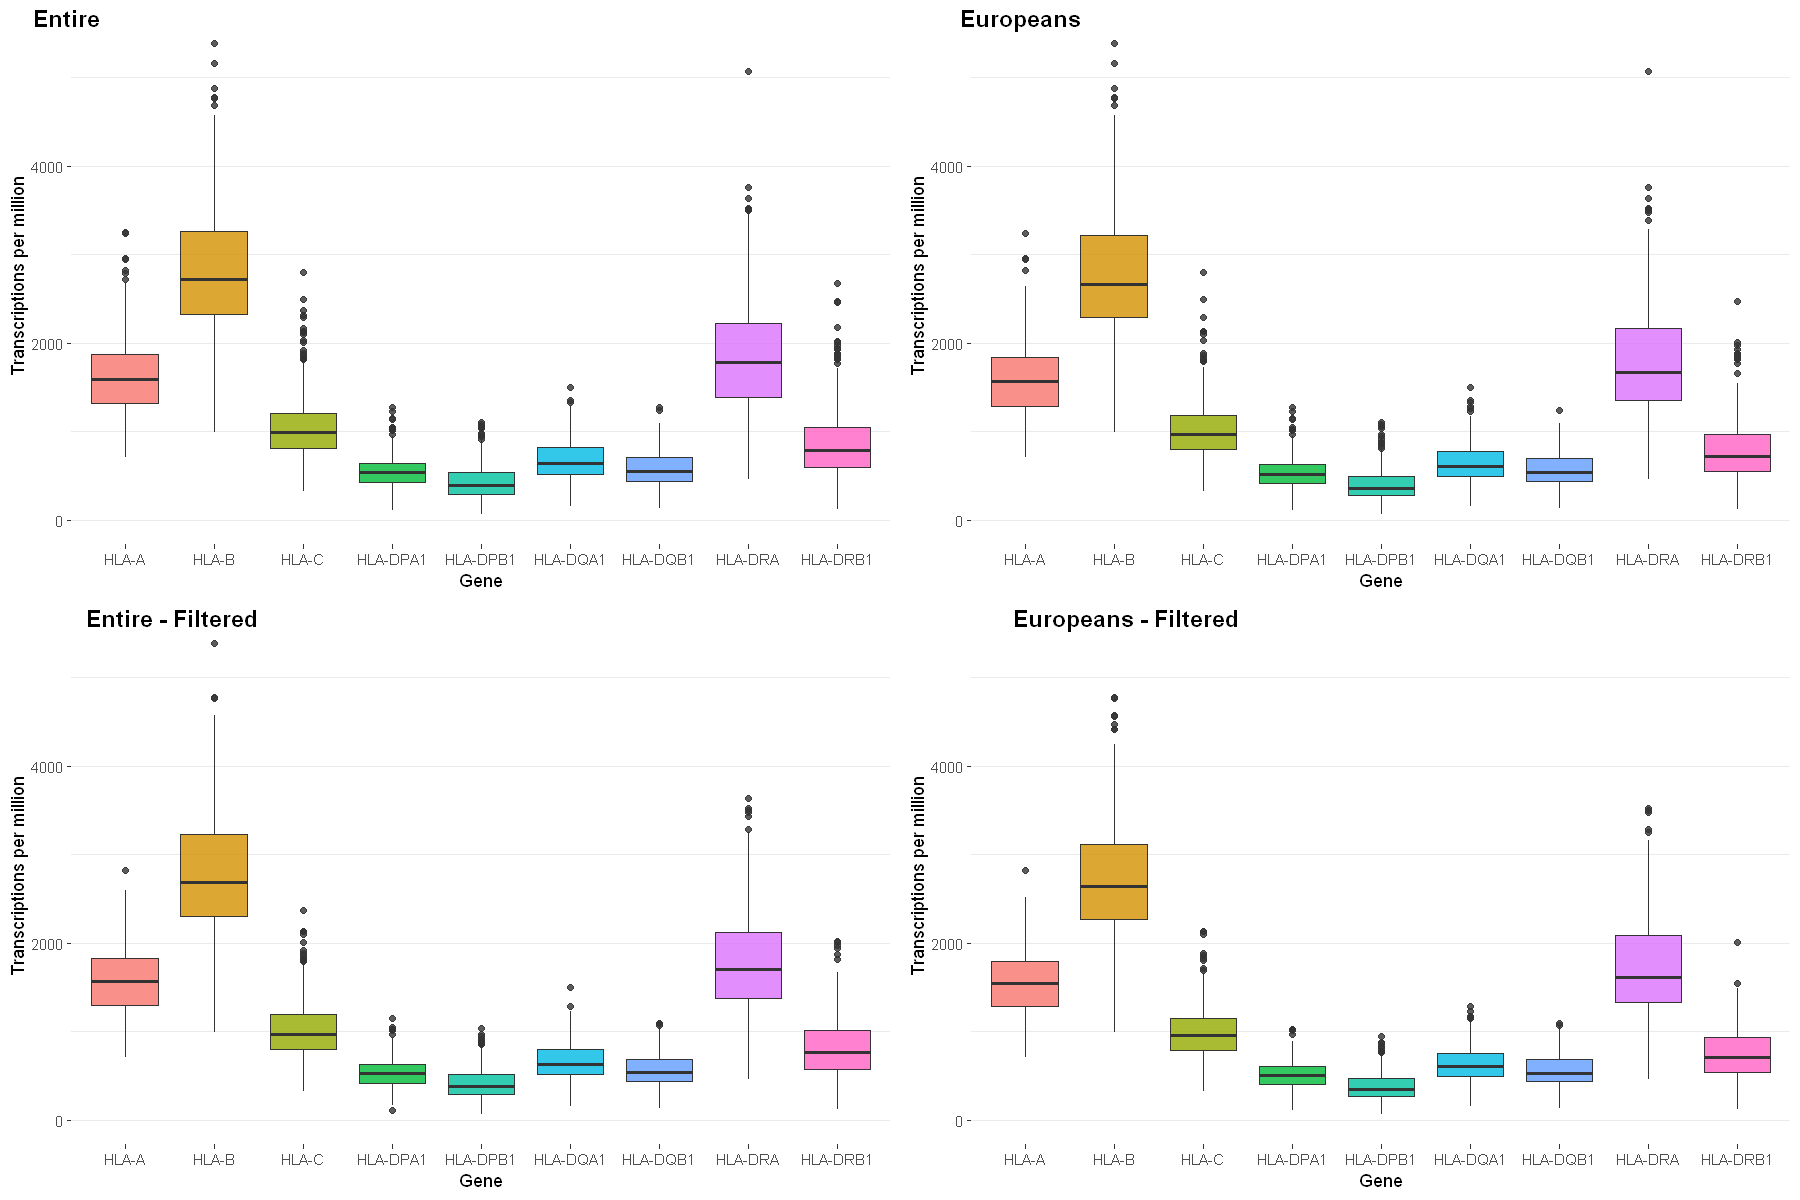

In [10]:
boxplotGenesPostAnalysis = function(sample_){
    bxPlt = hlaExp %>% 
    filter(subject_id %in% sample_) %>% 
    ggplot(aes(x = gene_name , y=tpm , fill = gene_name)) +
    geom_boxplot(alpha = .8) +
    theme_bw() +
    theme( 
          legend.position='none',
          panel.border = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) +
    scale_y_continuous(limits = c(0,5500)) +
    labs(x = 'Gene',y= "Transcriptions per million" , fill = 'Gene')
    return (bxPlt)
}
dfName_ = 'dfMahalanobisFull'
sample_ = get(dfName_)
pltBxPltFull = boxplotGenesPostAnalysis(sample_$subject_id)
dfName_ = 'dfMahalanobisEur'
sample_ = get(dfName_)
pltBxPltEur = boxplotGenesPostAnalysis(sample_$subject_id)
dfName_ = 'dfMahalanobisOut'
sample_ = get(dfName_)
pltBxPltFullOut = boxplotGenesPostAnalysis(sample_$subject_id)
dfName_ = 'dfMahalanobisEurOut'
sample_ = get(dfName_)
pltBxPltEurOut = boxplotGenesPostAnalysis(sample_$subject_id)

pltBxPlt = ggpubr::ggarrange( 
                    pltBxPltFull, pltBxPltEur, pltBxPltFullOut , pltBxPltEurOut ,
                    labels = c("Entire", "Europeans",'Entire - Filtered','Europeans - Filtered'),
                    ncol = 2, nrow = 2
                    )
pltBxPlt

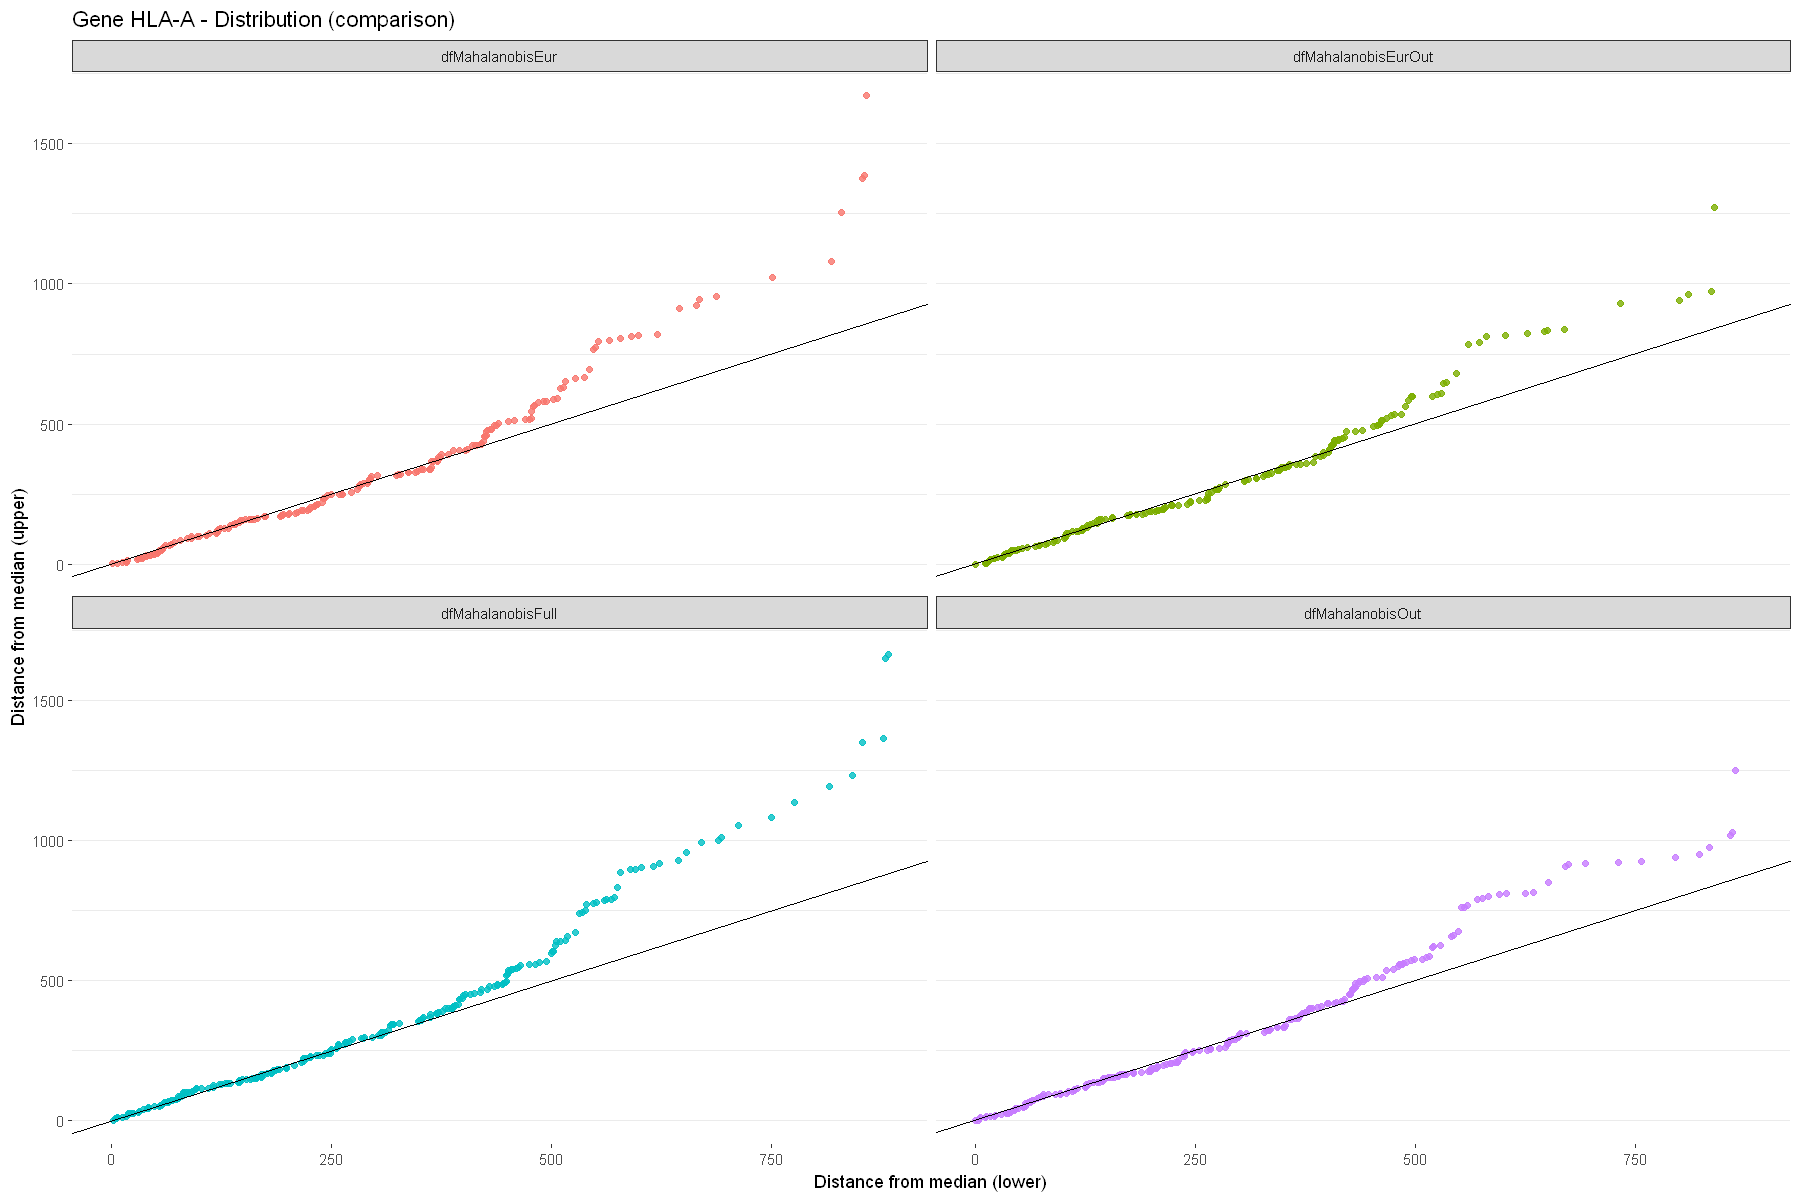

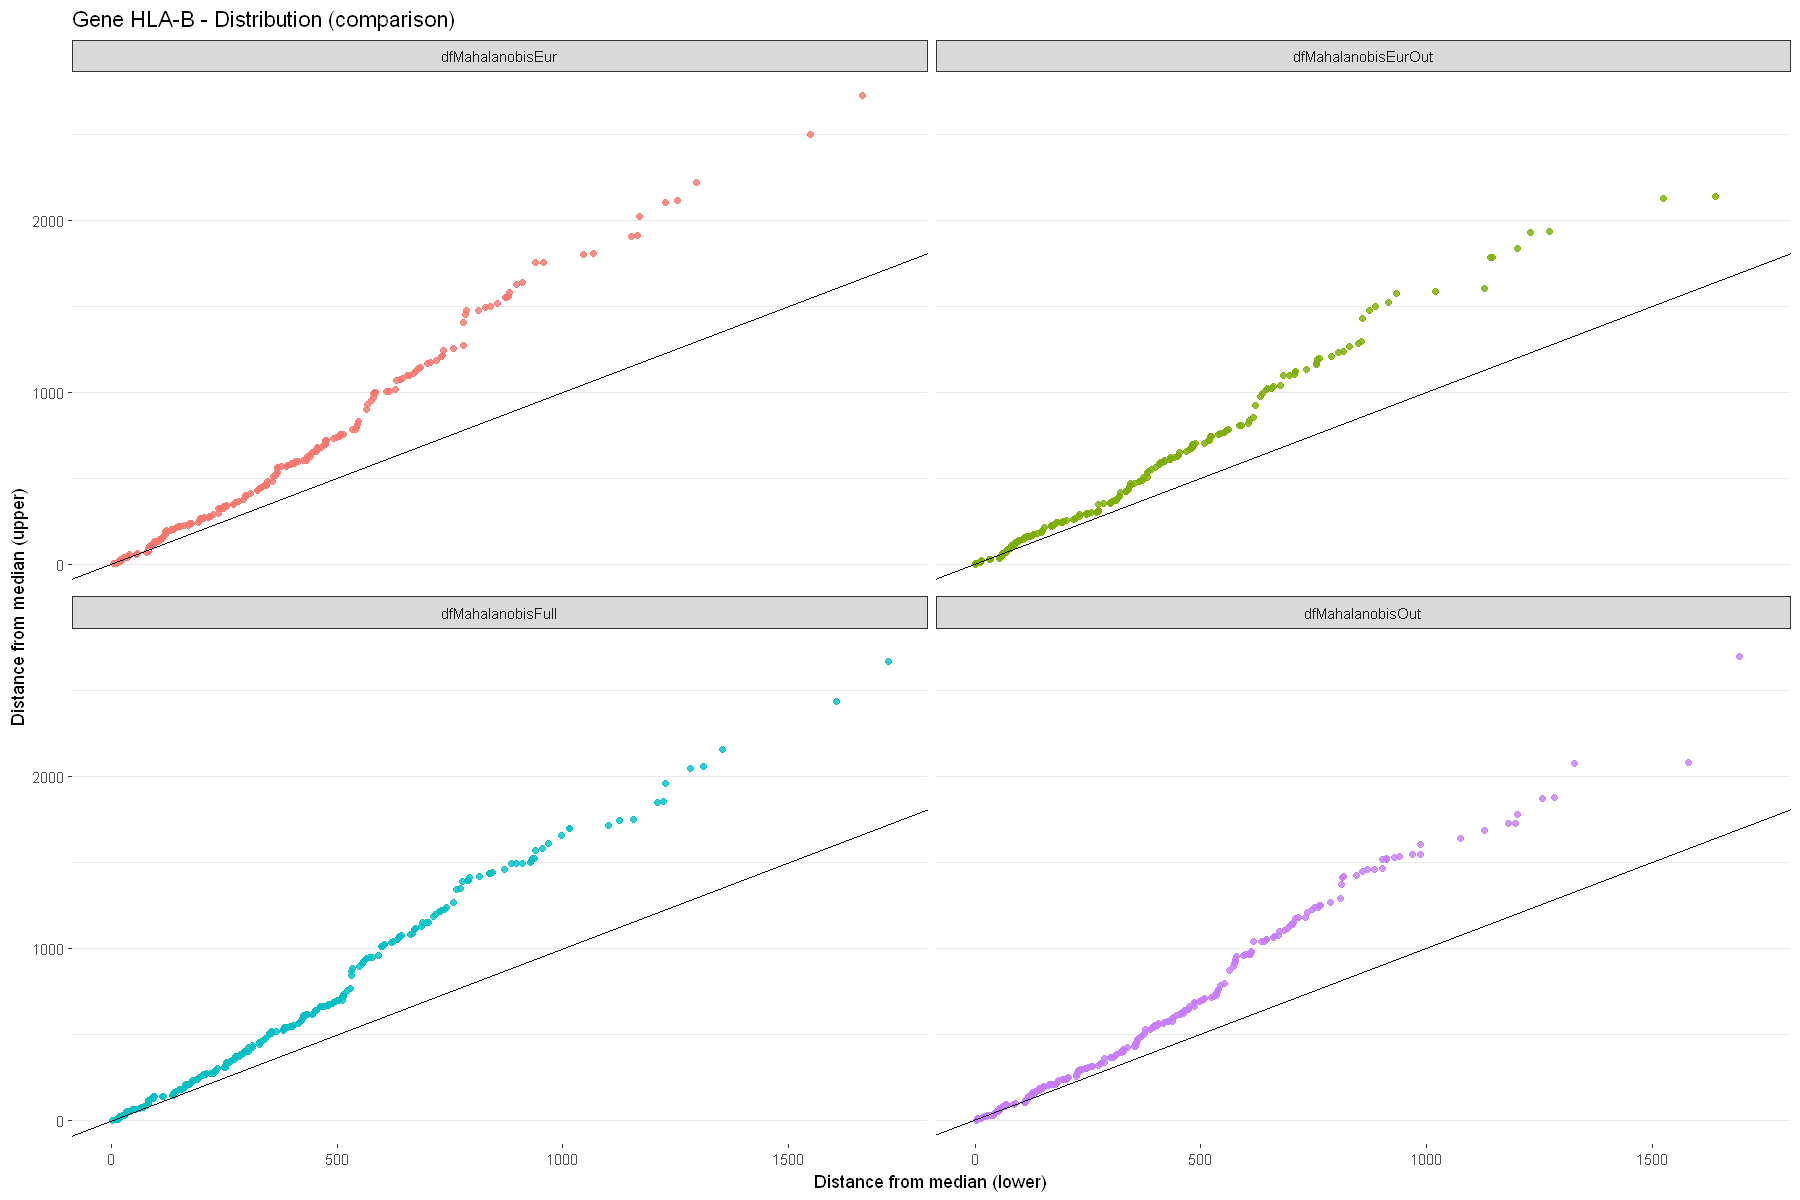

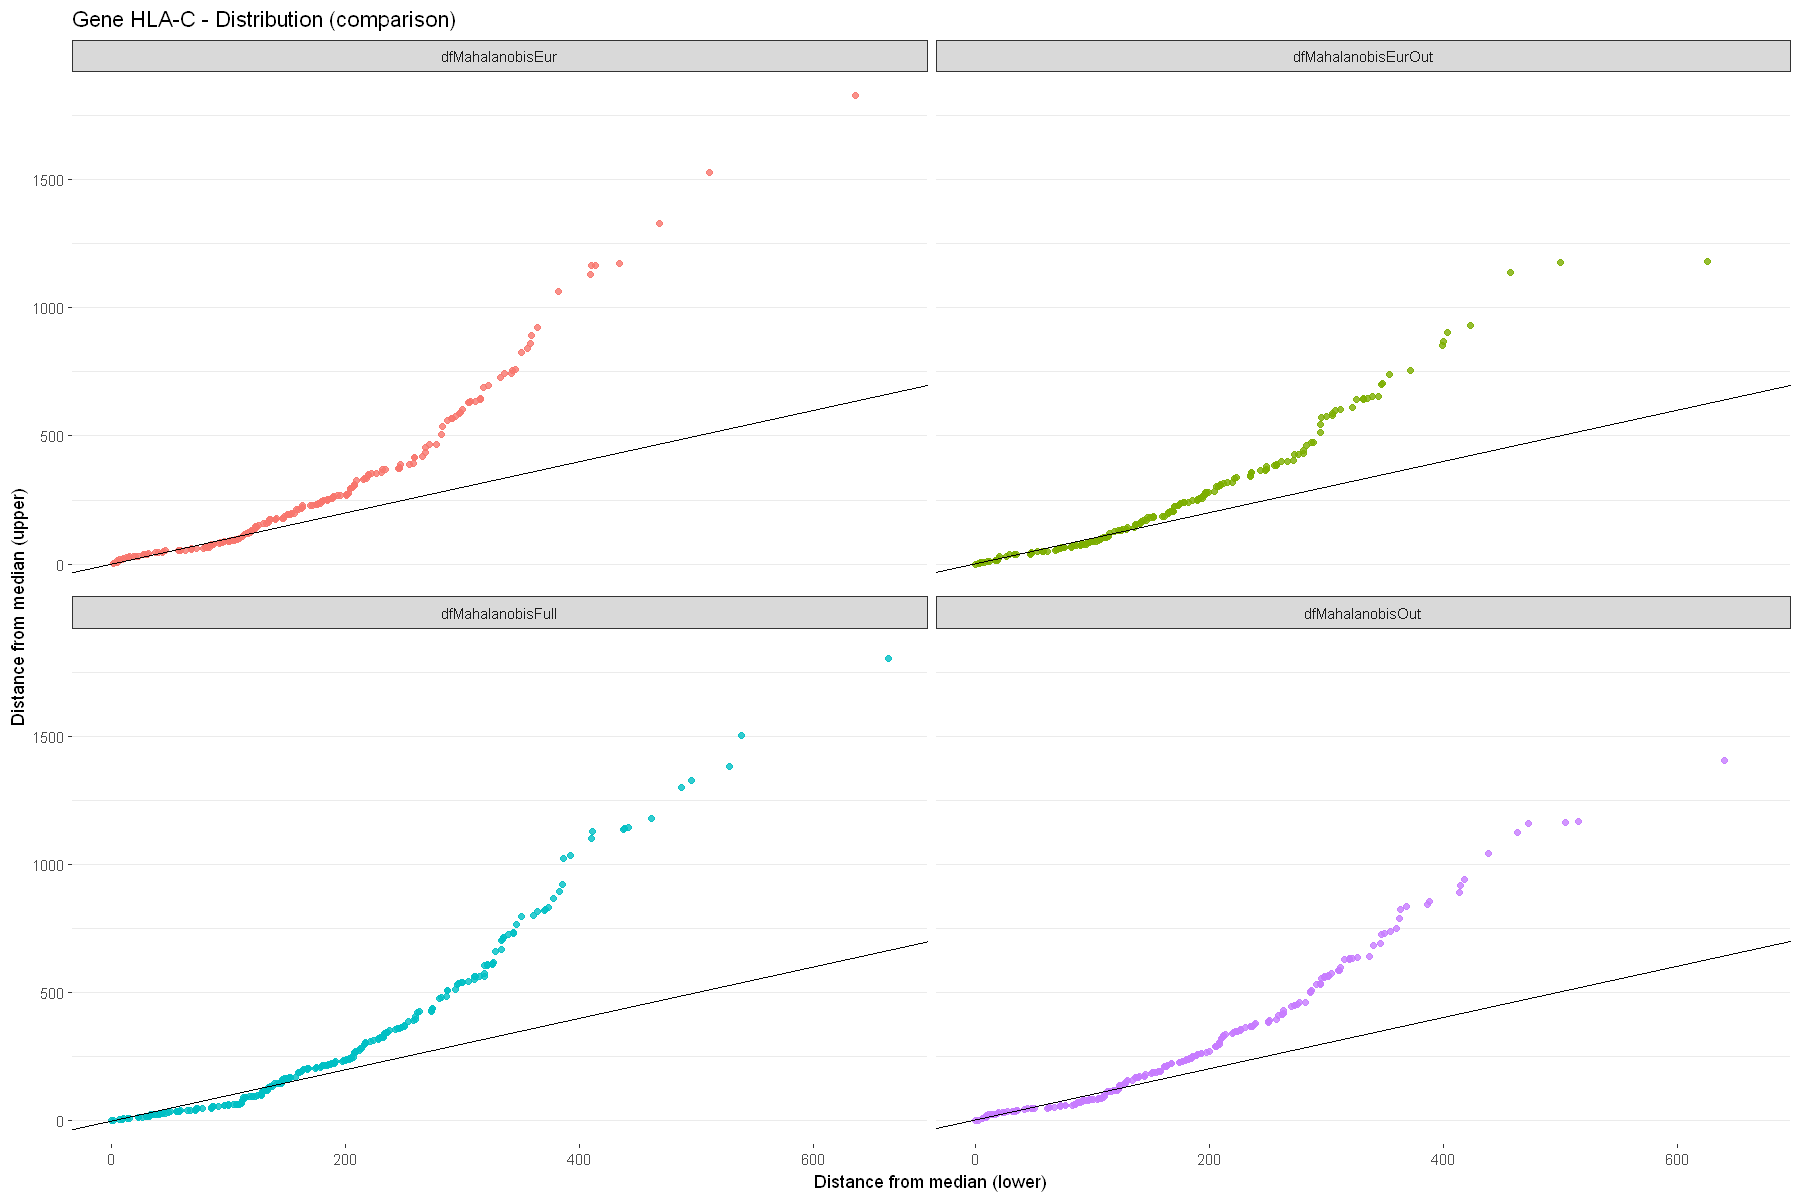

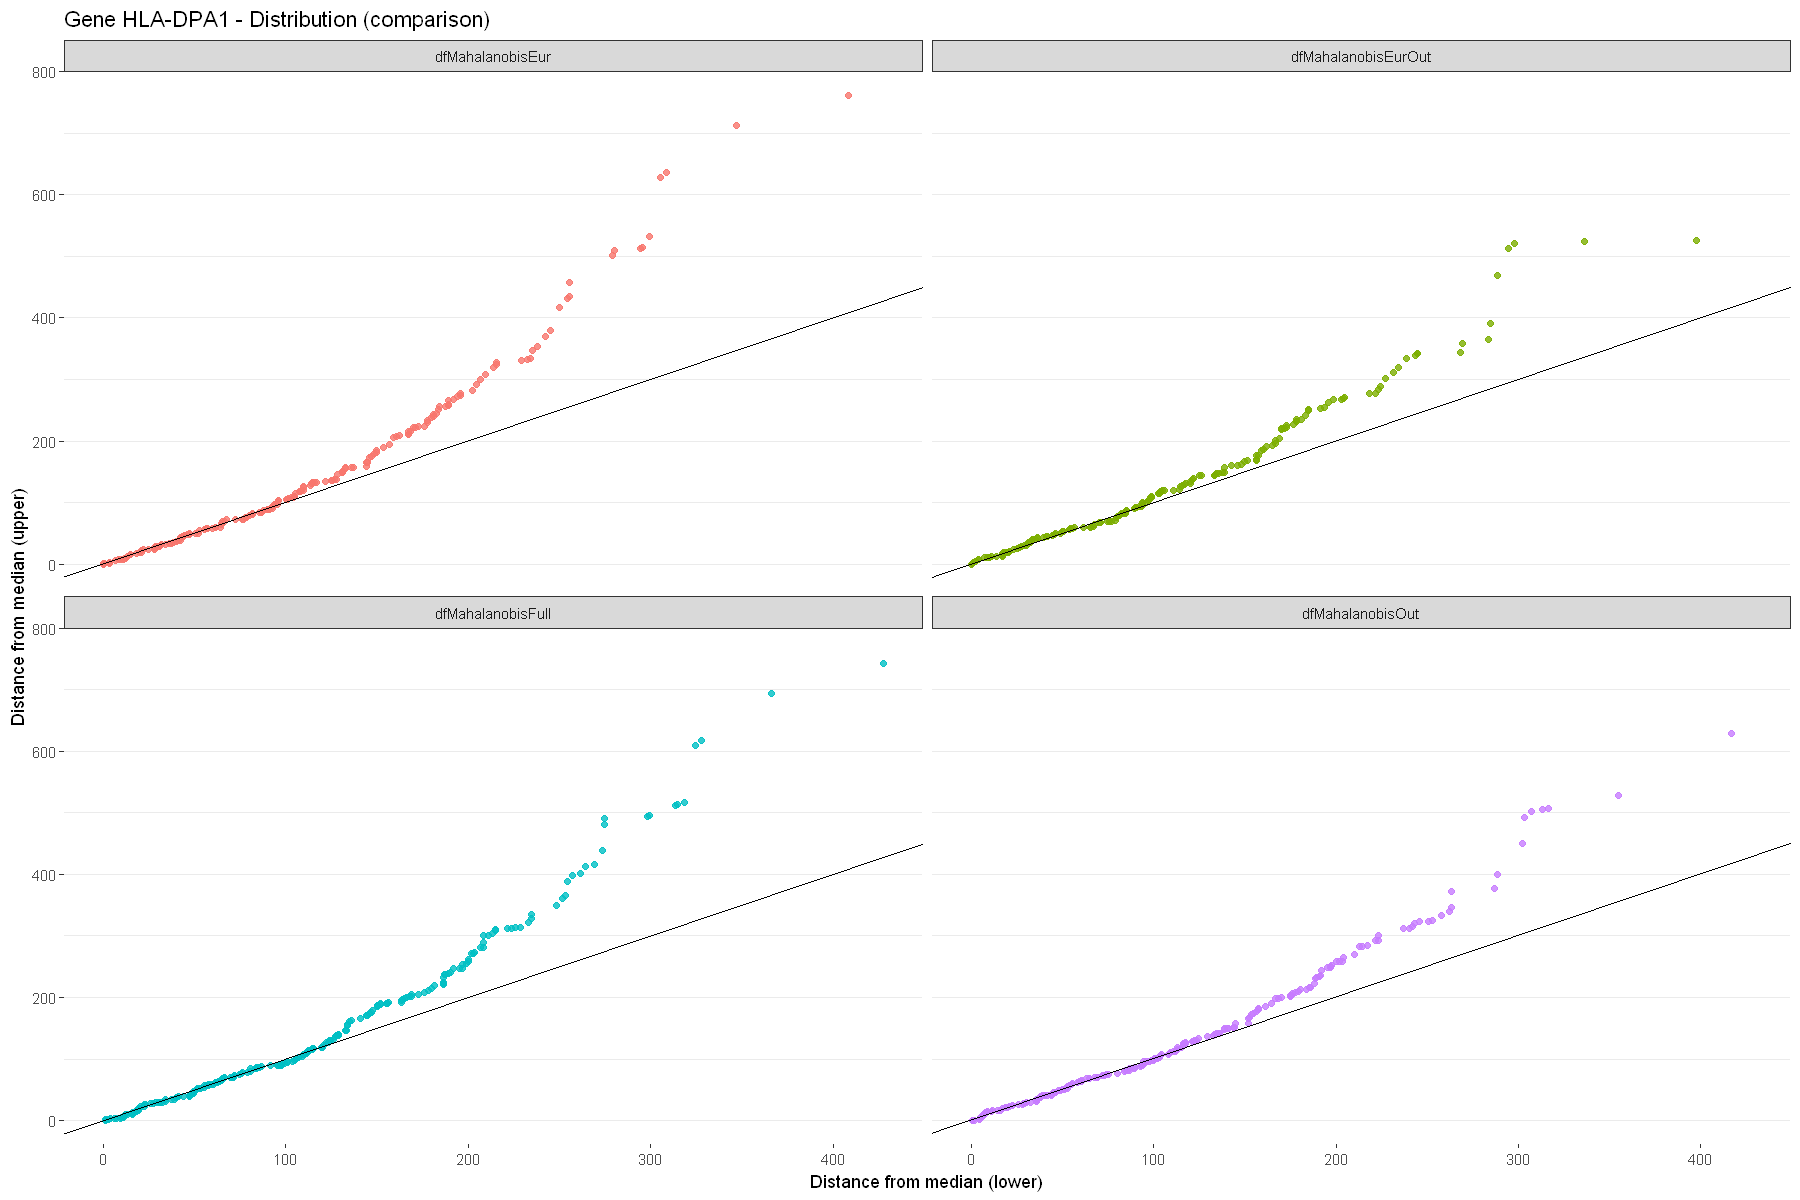

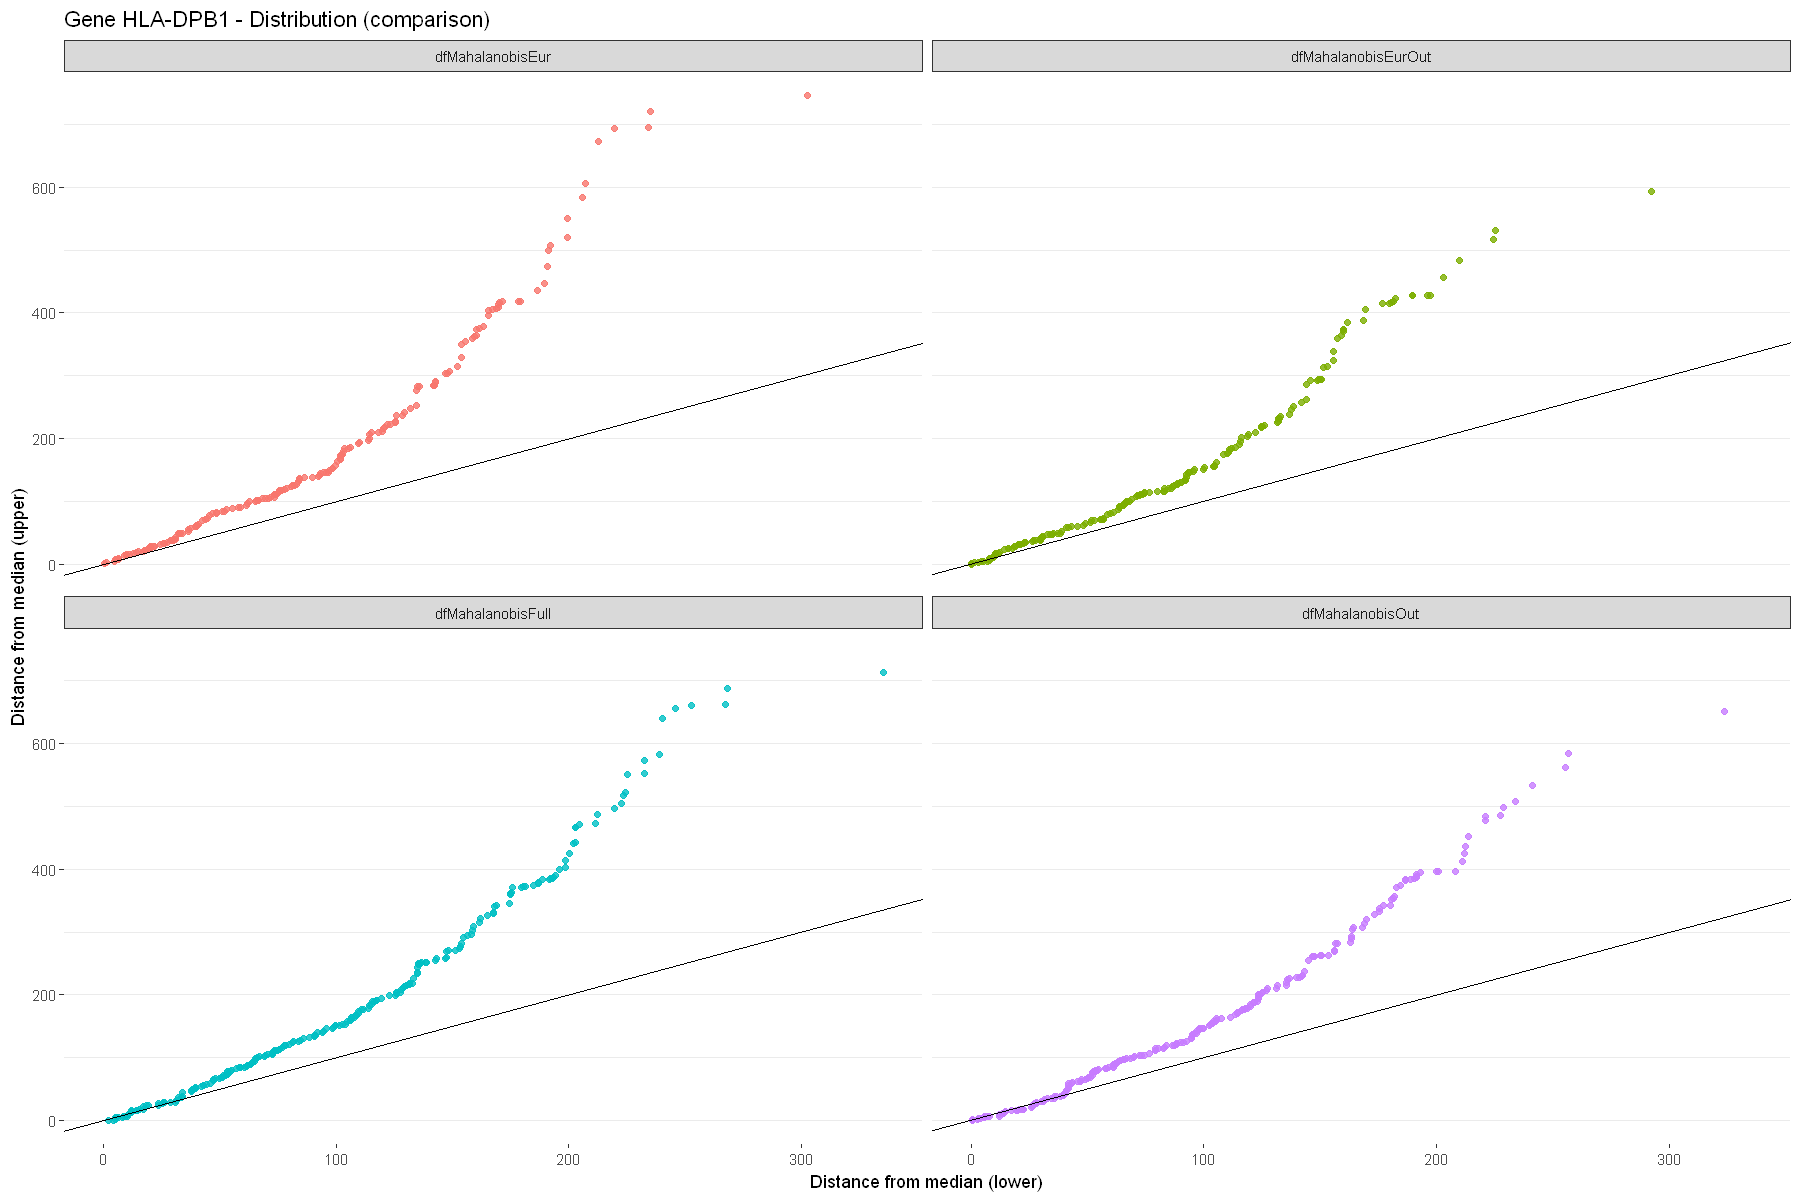

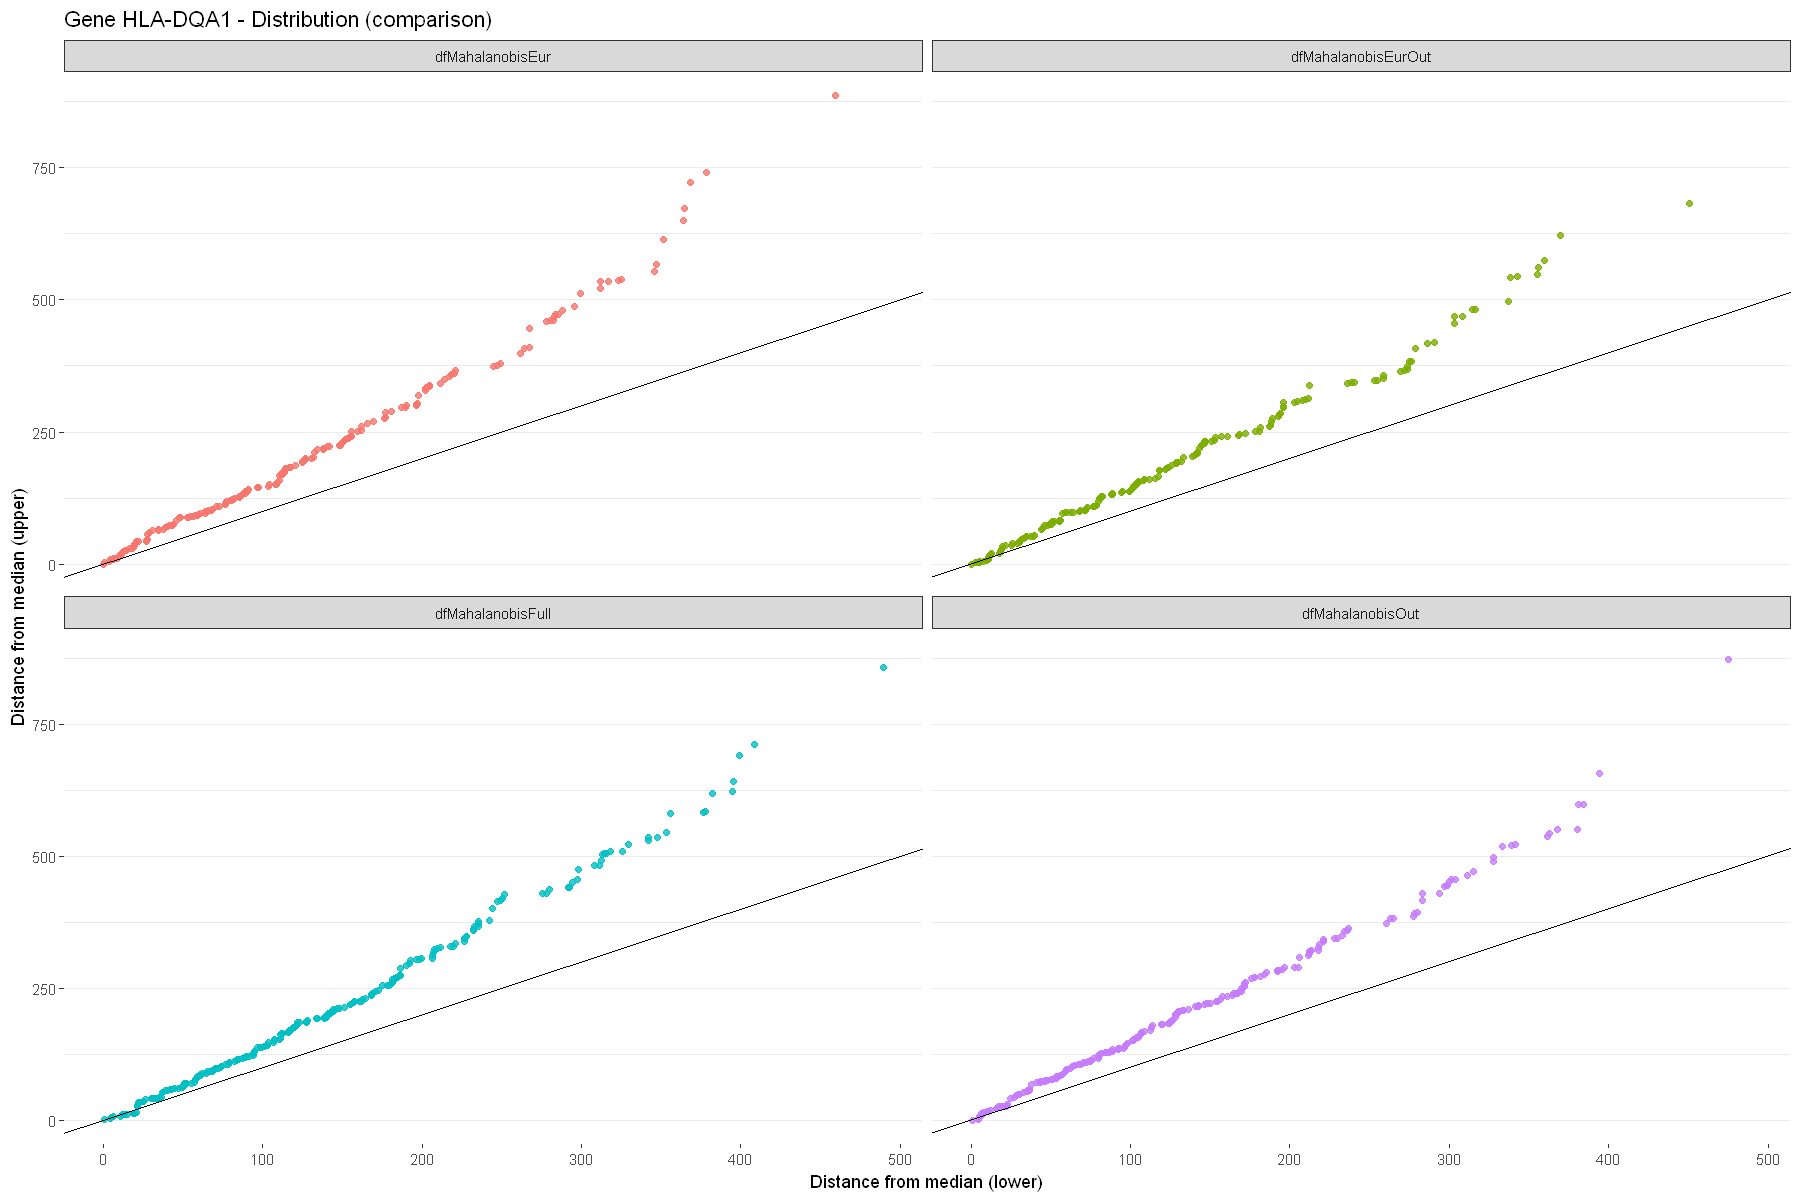

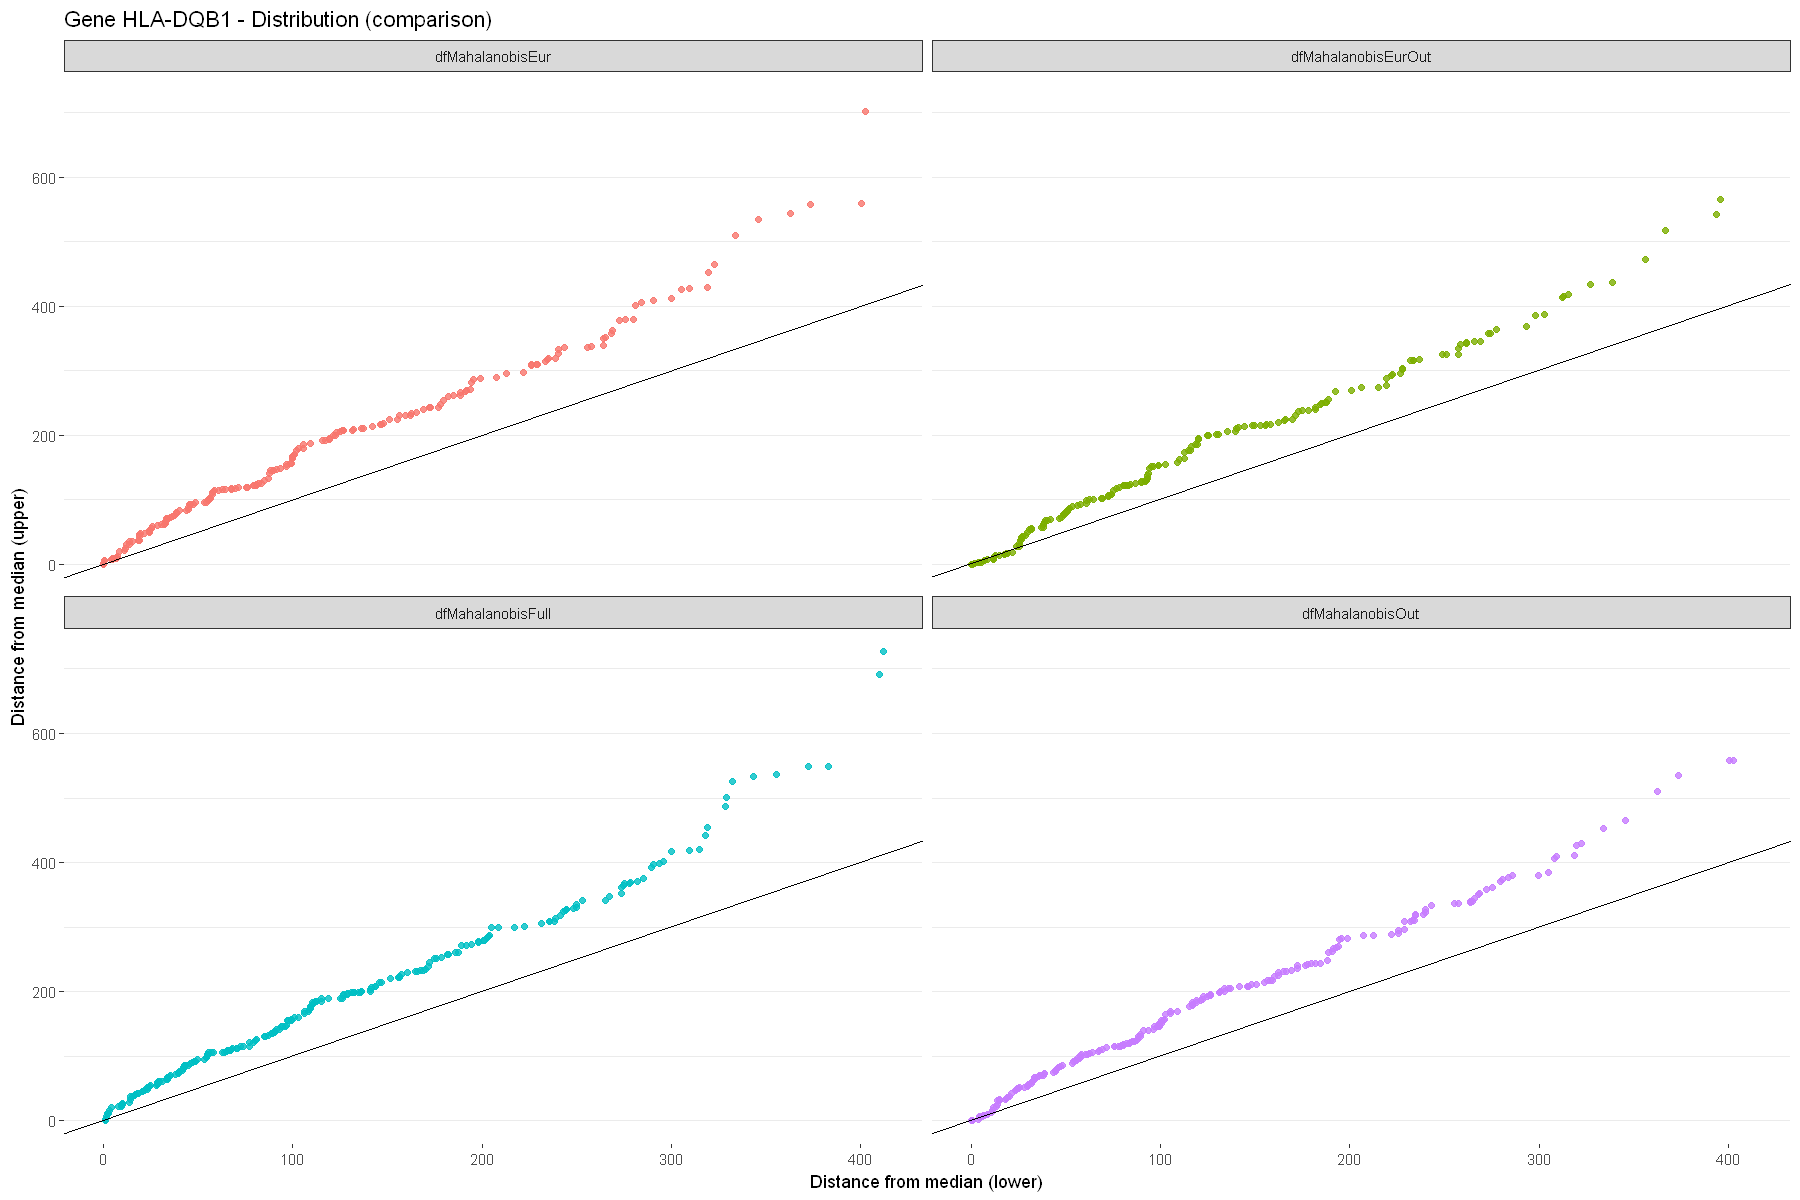

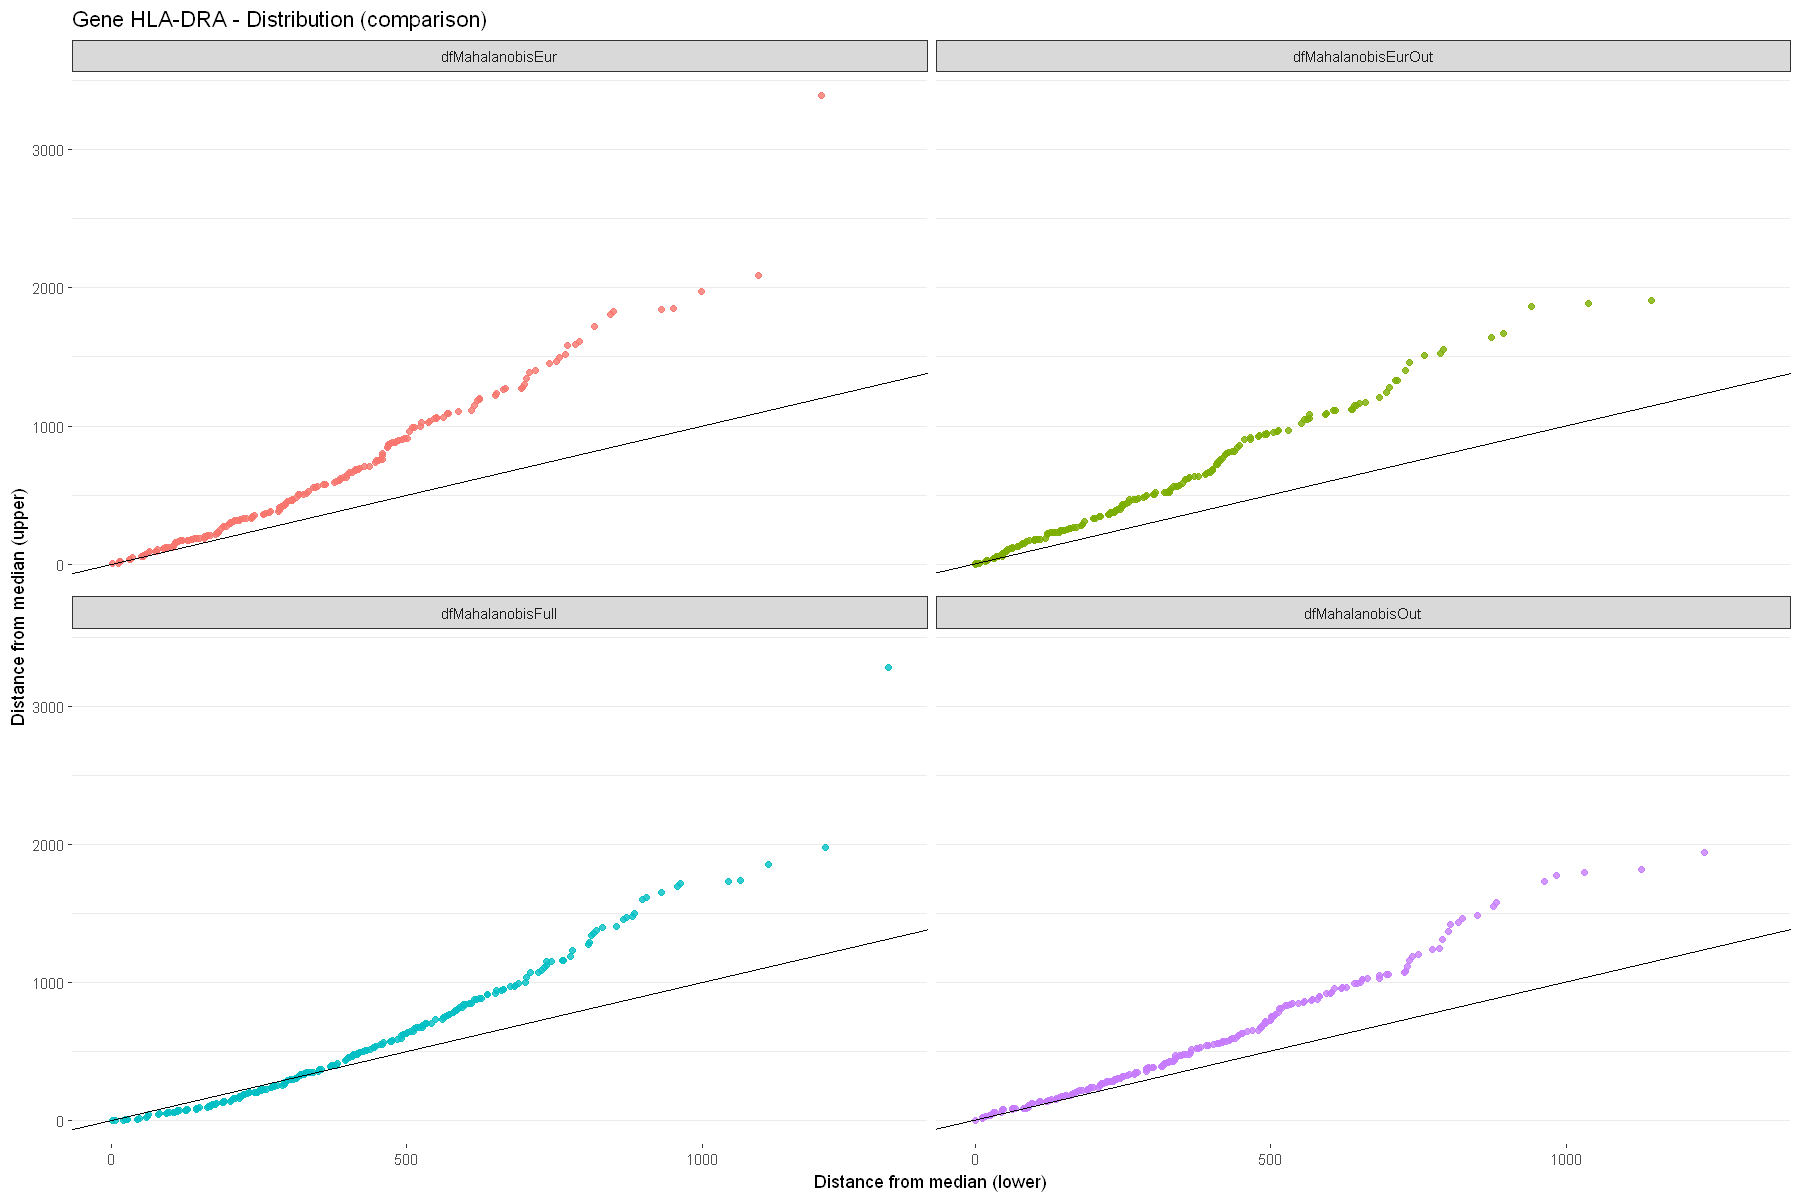

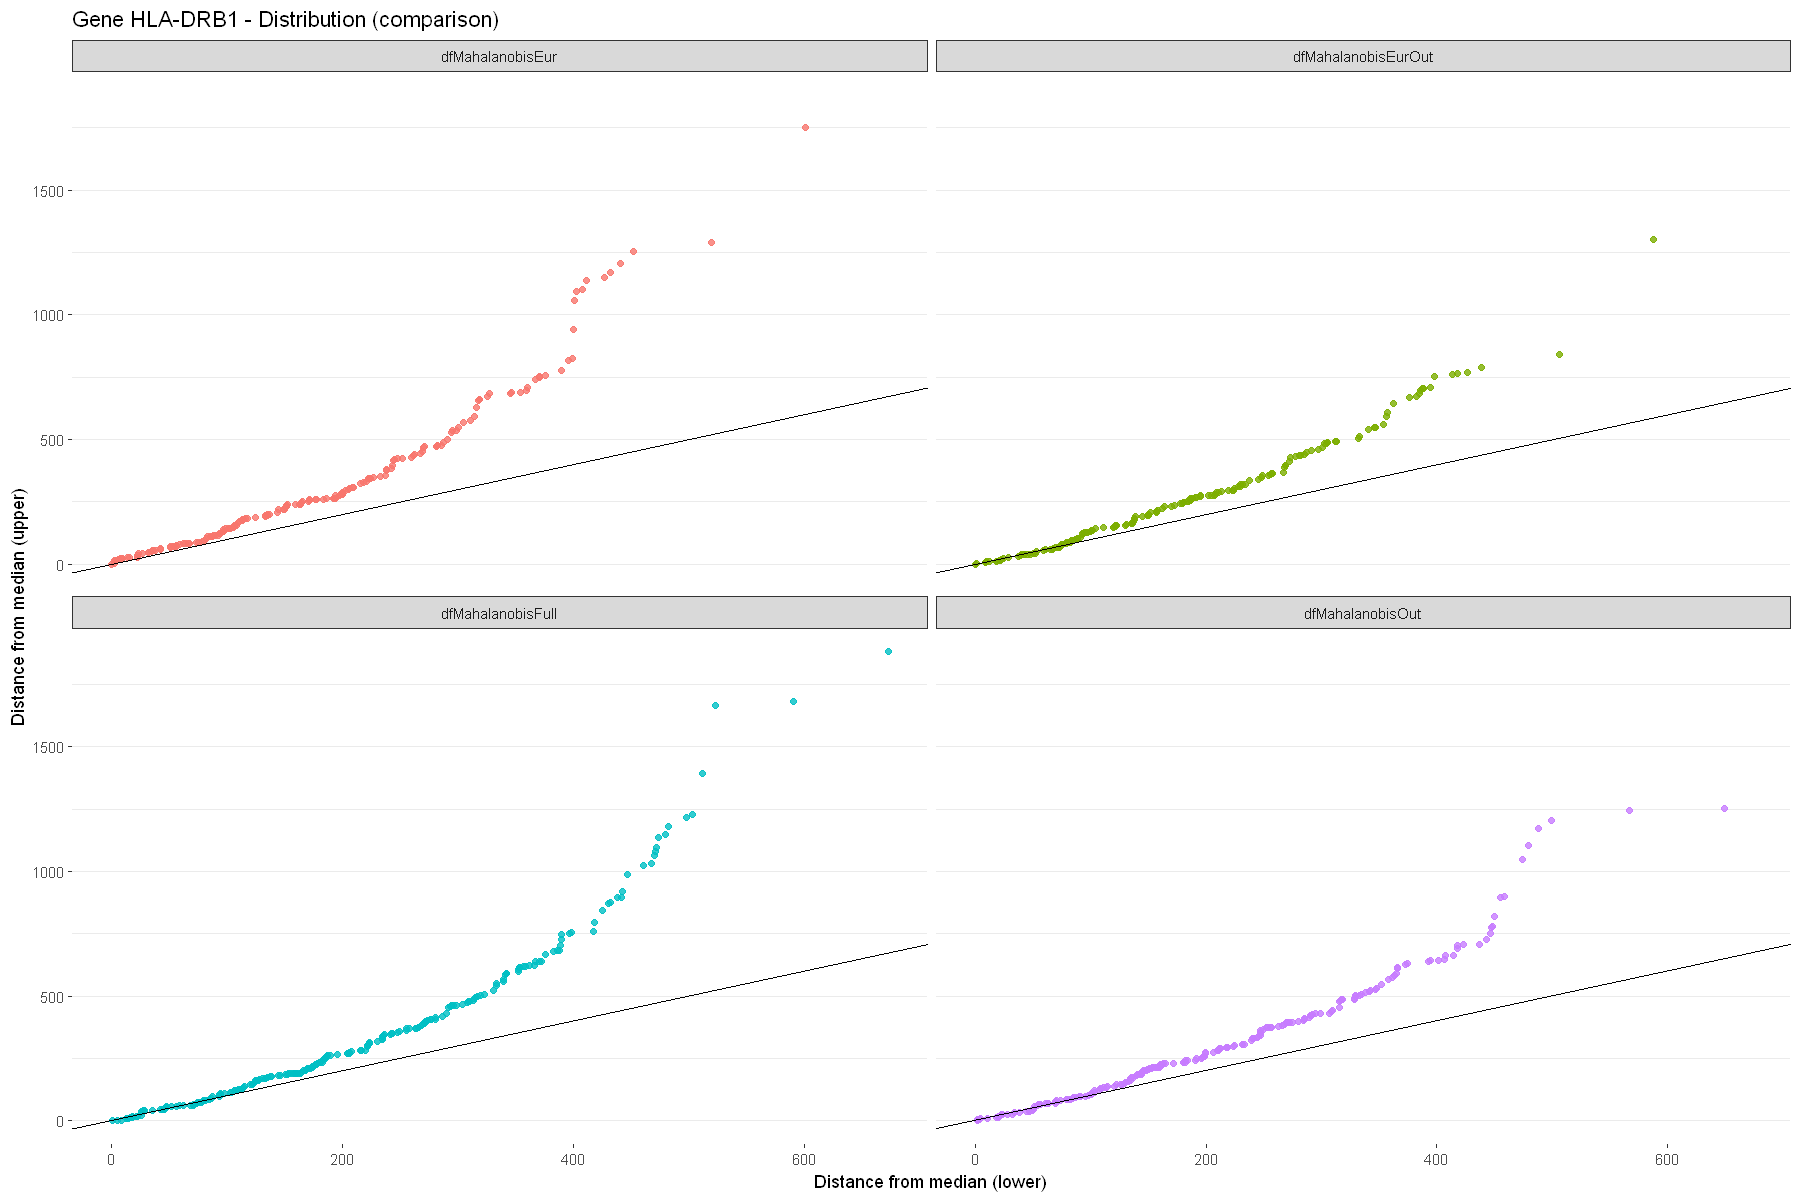

In [11]:
symmetryPltPostAnalysis = function(names_, gene_){
    # Creating data frame to plot assymetry
    dfSymmetryPhen_ = as.data.frame(NULL)

    for( name_ in names_ ){
        # For each gene:
        dfRef_ = get(name_)
        sample_ = dfRef_$subject_id
        # Filter gene associated information
        aux = hlaExp %>% 
        filter(gene_name == gene_) %>% 
        filter(subject_id %in% sample_)
        
        # Sort in ascending order gene expression (tpm)
        tpmSort_ = sort(aux$tpm)
        # Separate ordered set in two parts:
        # the 50% lower values - valuesInf_
        #  and the 50% greater values - valuesSup_
        # Then measure the distance to the median
        lengthSamp_ = length(tpmSort_)
        sizeParts_ = round(lengthSamp_/2)
        valuesInf_ = quantile(aux$tpm,.5) - tpmSort_[1:sizeParts_]
        valuesSup_ = tpmSort_[seq(from = lengthSamp_ , to = (lengthSamp_ - sizeParts_ + 1))] - quantile(aux$tpm,.5)
        # create auxiliary df to append info
        dfAppend_ = as.data.frame(valuesInf_)
        dfAppend_$Sup_ = valuesSup_
        dfAppend_$name_ = name_
        # Append in final df
        dfSymmetryPhen_ = rbind(dfSymmetryPhen_ , dfAppend_)
    }
    colnames(dfSymmetryPhen_)[1] = 'Inf_'
    plotSymmetry_ = dfSymmetryPhen_ %>% ggplot(aes(x = Inf_ , y = Sup_ , colour = name_)) +
    geom_point(alpha = .8) +
    geom_abline(intercept = 0 , slope = 1) +
    theme_bw() +
    theme( 
          legend.position='none',
          panel.border = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) +
    facet_wrap(~name_ , scales = 'fixed')+
    labs(x = "Distance from median (lower)" , 
         y= 'Distance from median (upper)' , 
         colour = 'Gene', 
         title = paste0("Gene ", gene_, " - Distribution (comparison)")
        )
    return(plotSymmetry_)
}
names_ = c('dfMahalanobisFull', 'dfMahalanobisEur', 'dfMahalanobisOut', 'dfMahalanobisEurOut')
for(gene_ in genesLoop){
    pltSymFull = symmetryPltPostAnalysis(names_, gene_)
    print(pltSymFull)
}

In [12]:
normalComparisonDf = as.data.frame(NULL)
cont_ = 1
for( idx_ in 1:length(genesLoop) ){
    gene_ = genesLoop[idx_]
    for( name_ in names_ ){
        # For each gene:
        dfRef_ = get(name_)
        sample_ = dfRef_$subject_id
        # Filter gene associated information
        aux = hlaExp %>% 
        filter(gene_name == gene_) %>% 
        filter(subject_id %in% sample_)
        # Calculate metrics
        ks_ = ks.test(aux$tpm,'pnorm',mean(aux$tpm),sd(aux$tpm))
        ad_ = nortest::ad.test(aux$tpm)
        check_ = length(unique(aux$tpm)) == nrow(aux)
        normalComparisonDf[cont_,'Gene'] = gene_
        normalComparisonDf[cont_,'Sample'] = name_
        normalComparisonDf[cont_,'KS'] = ks_$p.value
        normalComparisonDf[cont_,'AD'] = ad_$p.value
        normalComparisonDf[cont_,'Ties'] = ifelse(check_ == T , 'No' , 'Yes')
        normalComparisonDf[cont_,'Skewness'] = moments::skewness(aux$tpm)
        normalComparisonDf[cont_,'Kurtosis'] = moments::kurtosis(aux$tpm)
        cont_ = cont_ + 1
    }
}

Warning message in ks.test(aux$tpm, "pnorm", mean(aux$tpm), sd(aux$tpm)):
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test(aux$tpm, "pnorm", mean(aux$tpm), sd(aux$tpm)):
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test(aux$tpm, "pnorm", mean(aux$tpm), sd(aux$tpm)):
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test(aux$tpm, "pnorm", mean(aux$tpm), sd(aux$tpm)):
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test(aux$tpm, "pnorm", mean(aux$tpm), sd(aux$tpm)):
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test(aux$tpm, "pnorm", mean(aux$tpm), sd(aux$tpm)):
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test(aux$tpm, "pnorm", mean(aux$tpm), sd(aux$tpm)):
"ties should not be present for the Kolmogorov-Smirnov test"
Warning message in ks.test(aux$tpm, "pnorm", mean(aux$t

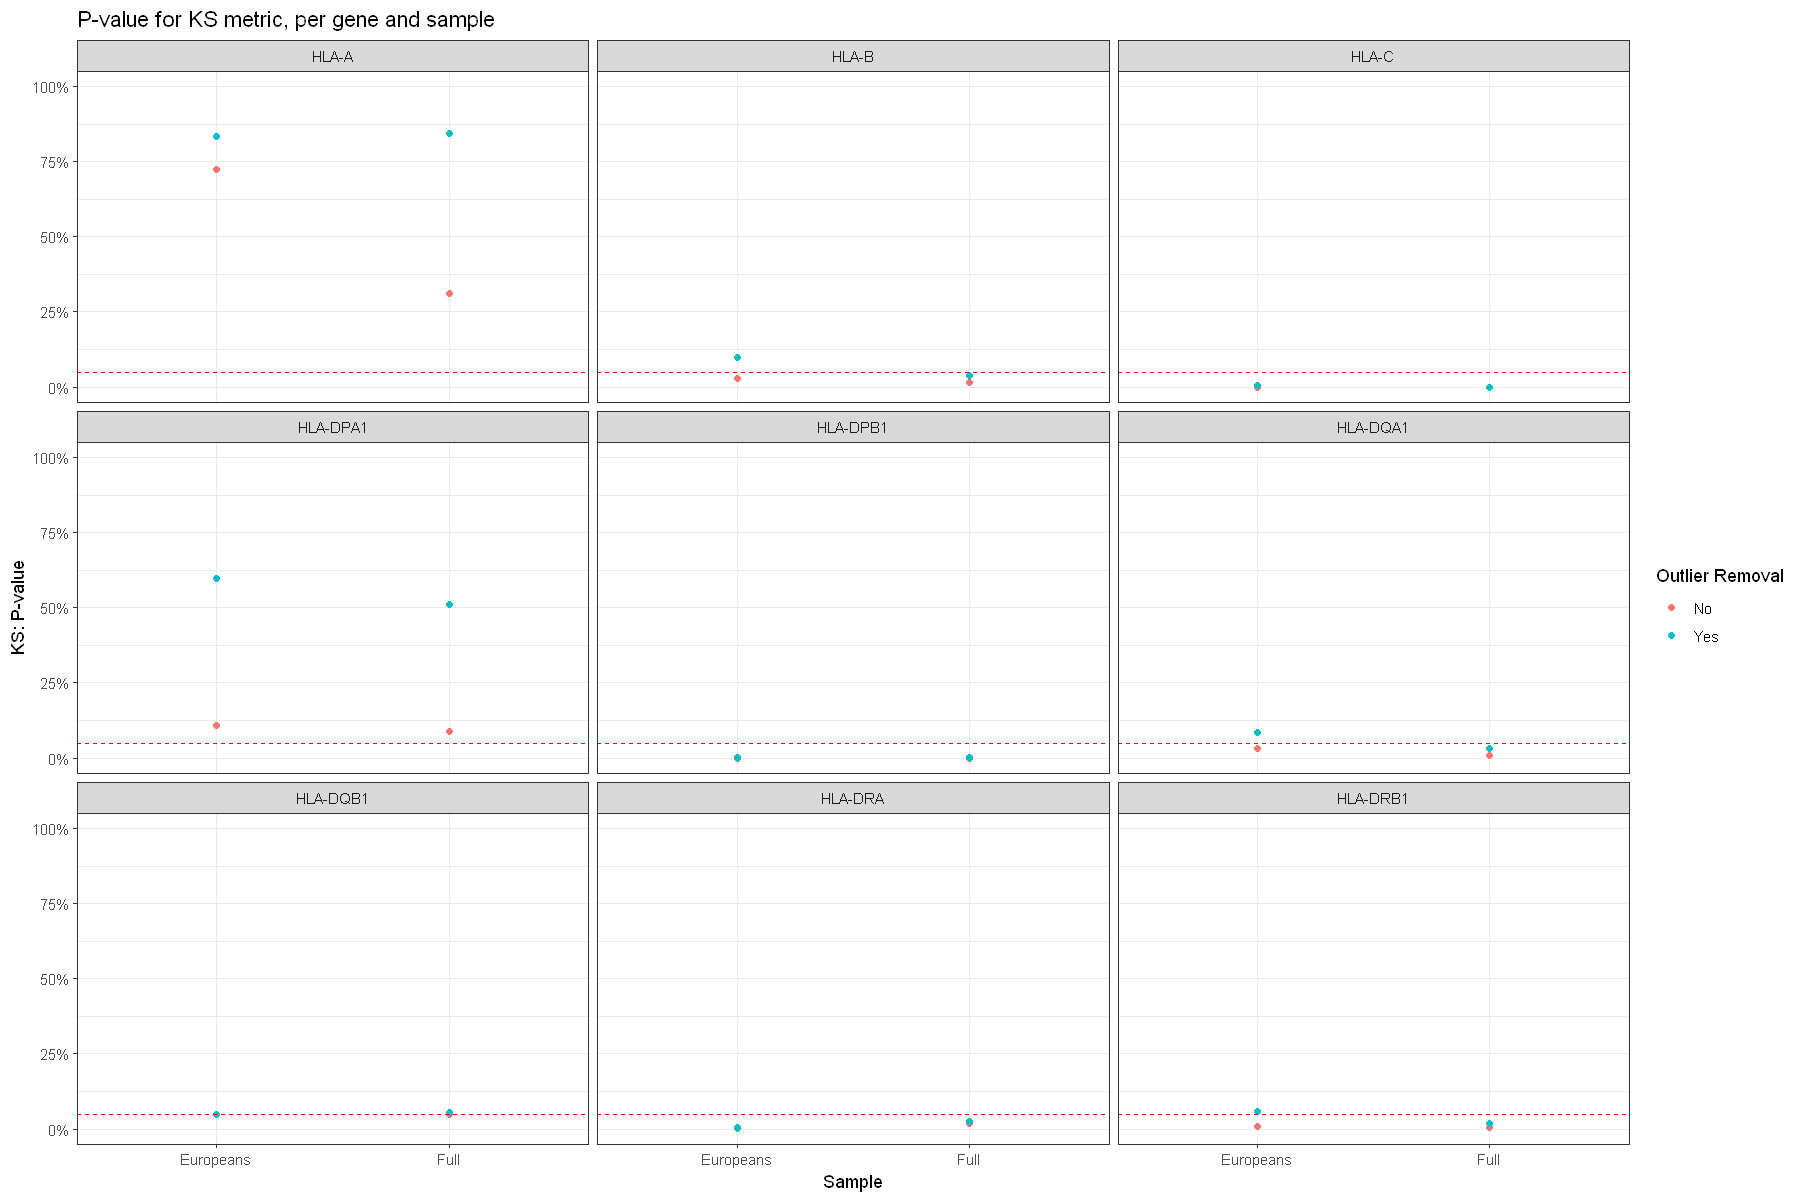

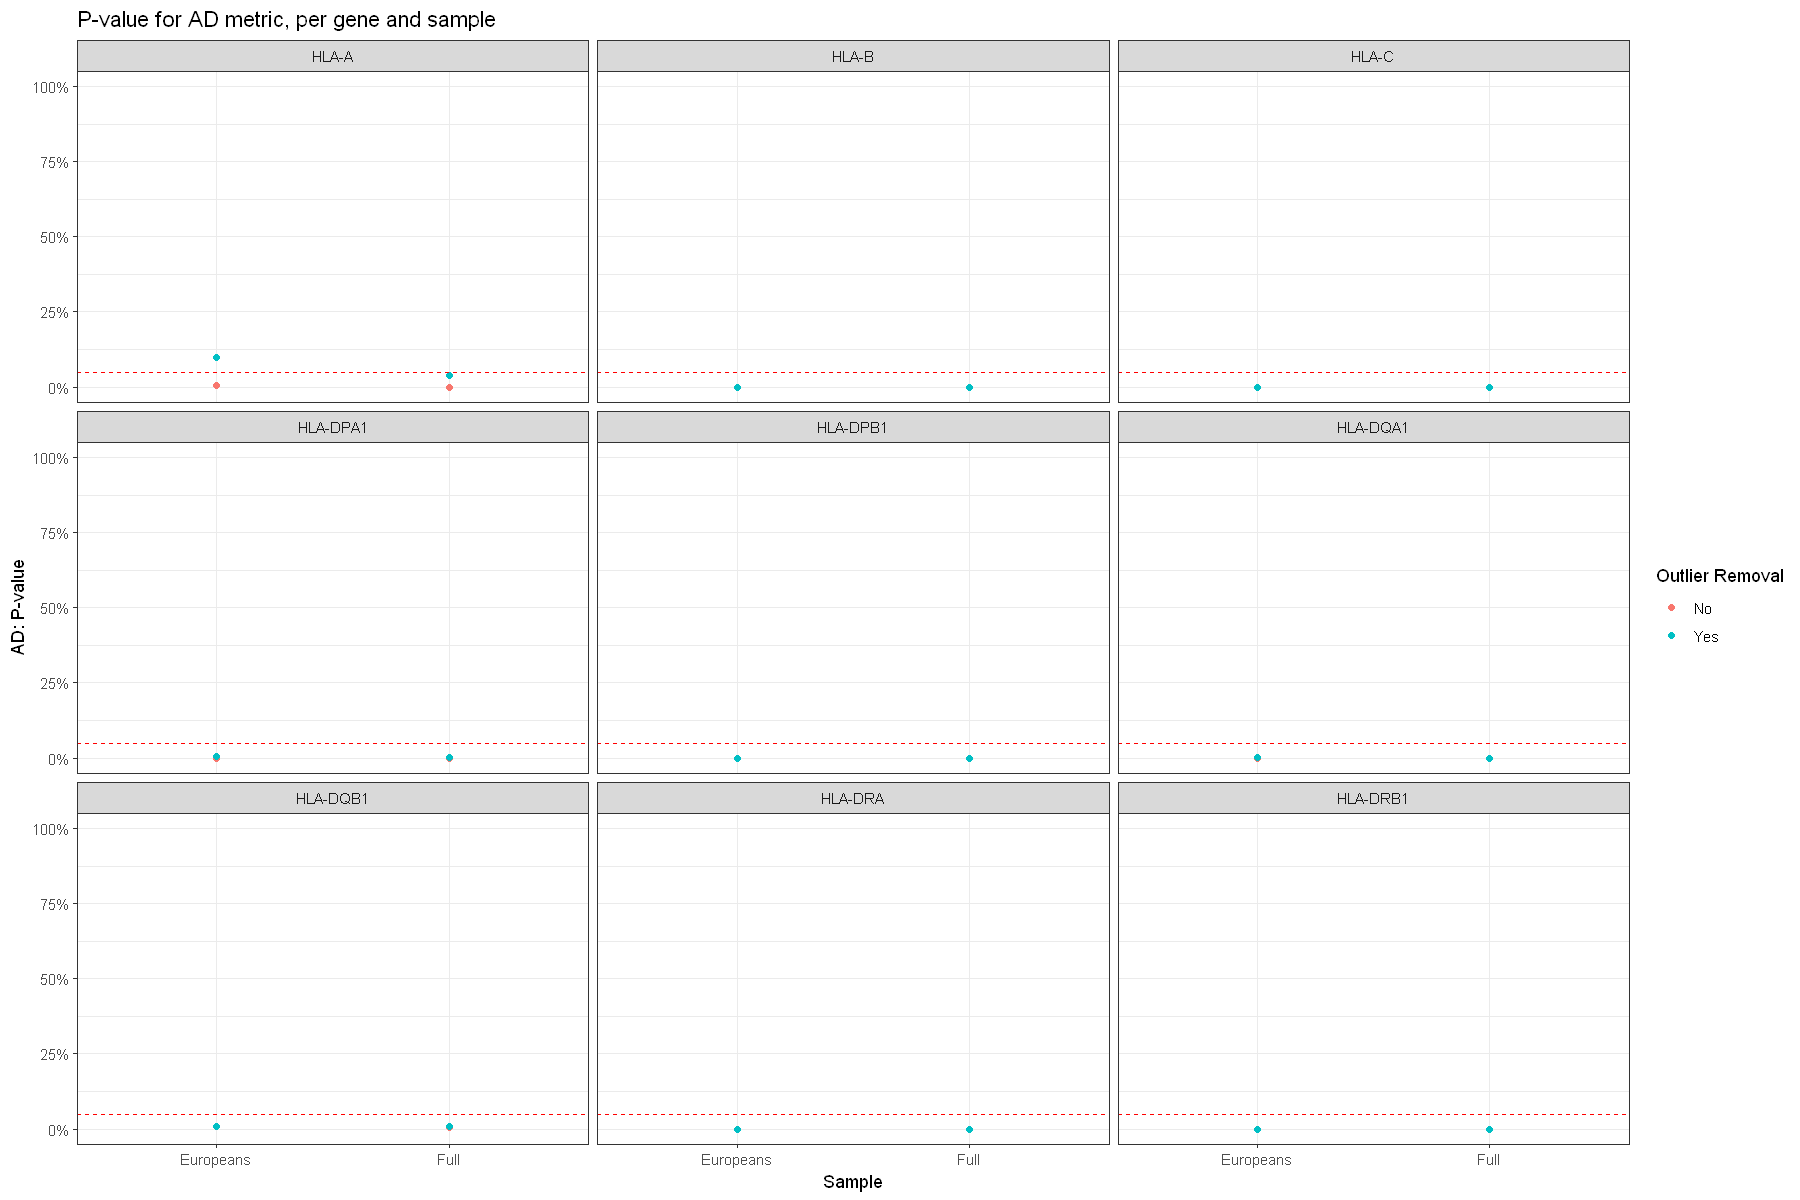

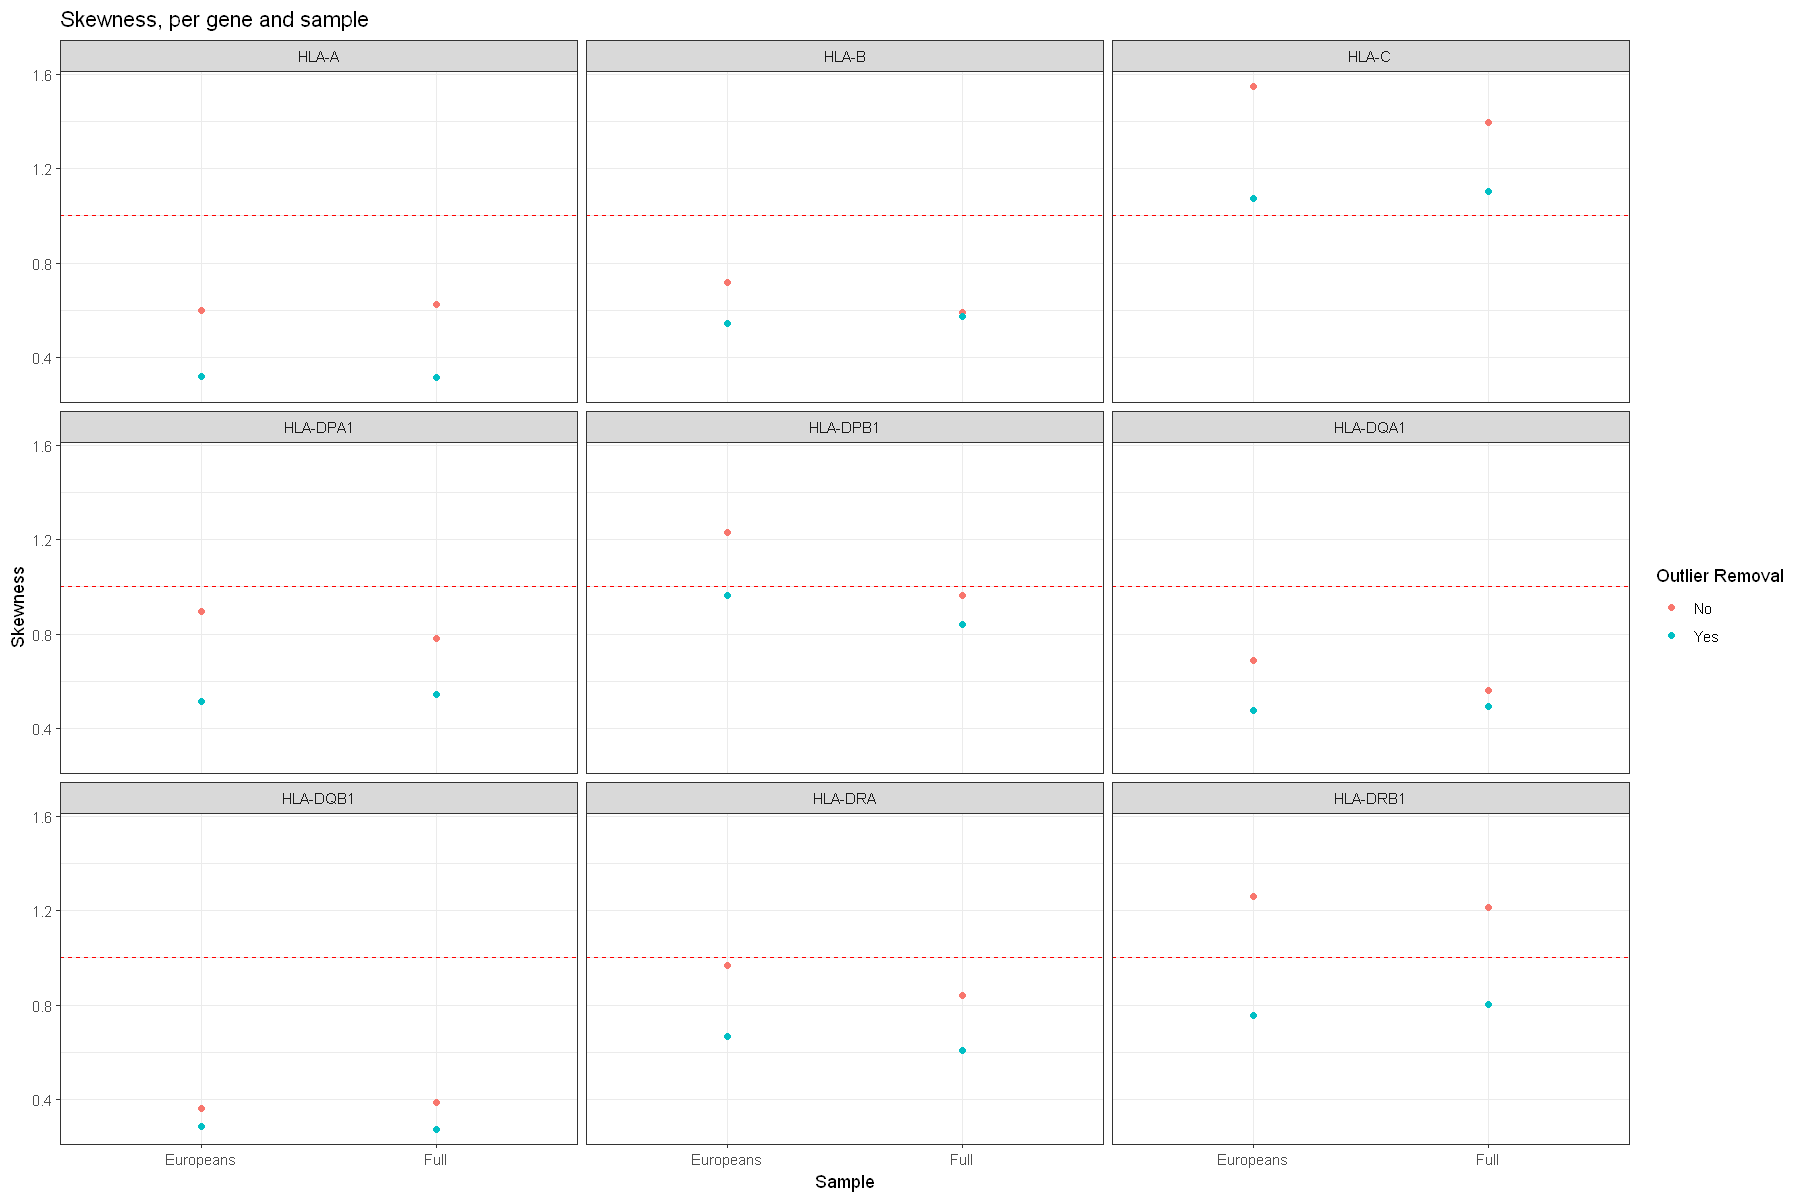

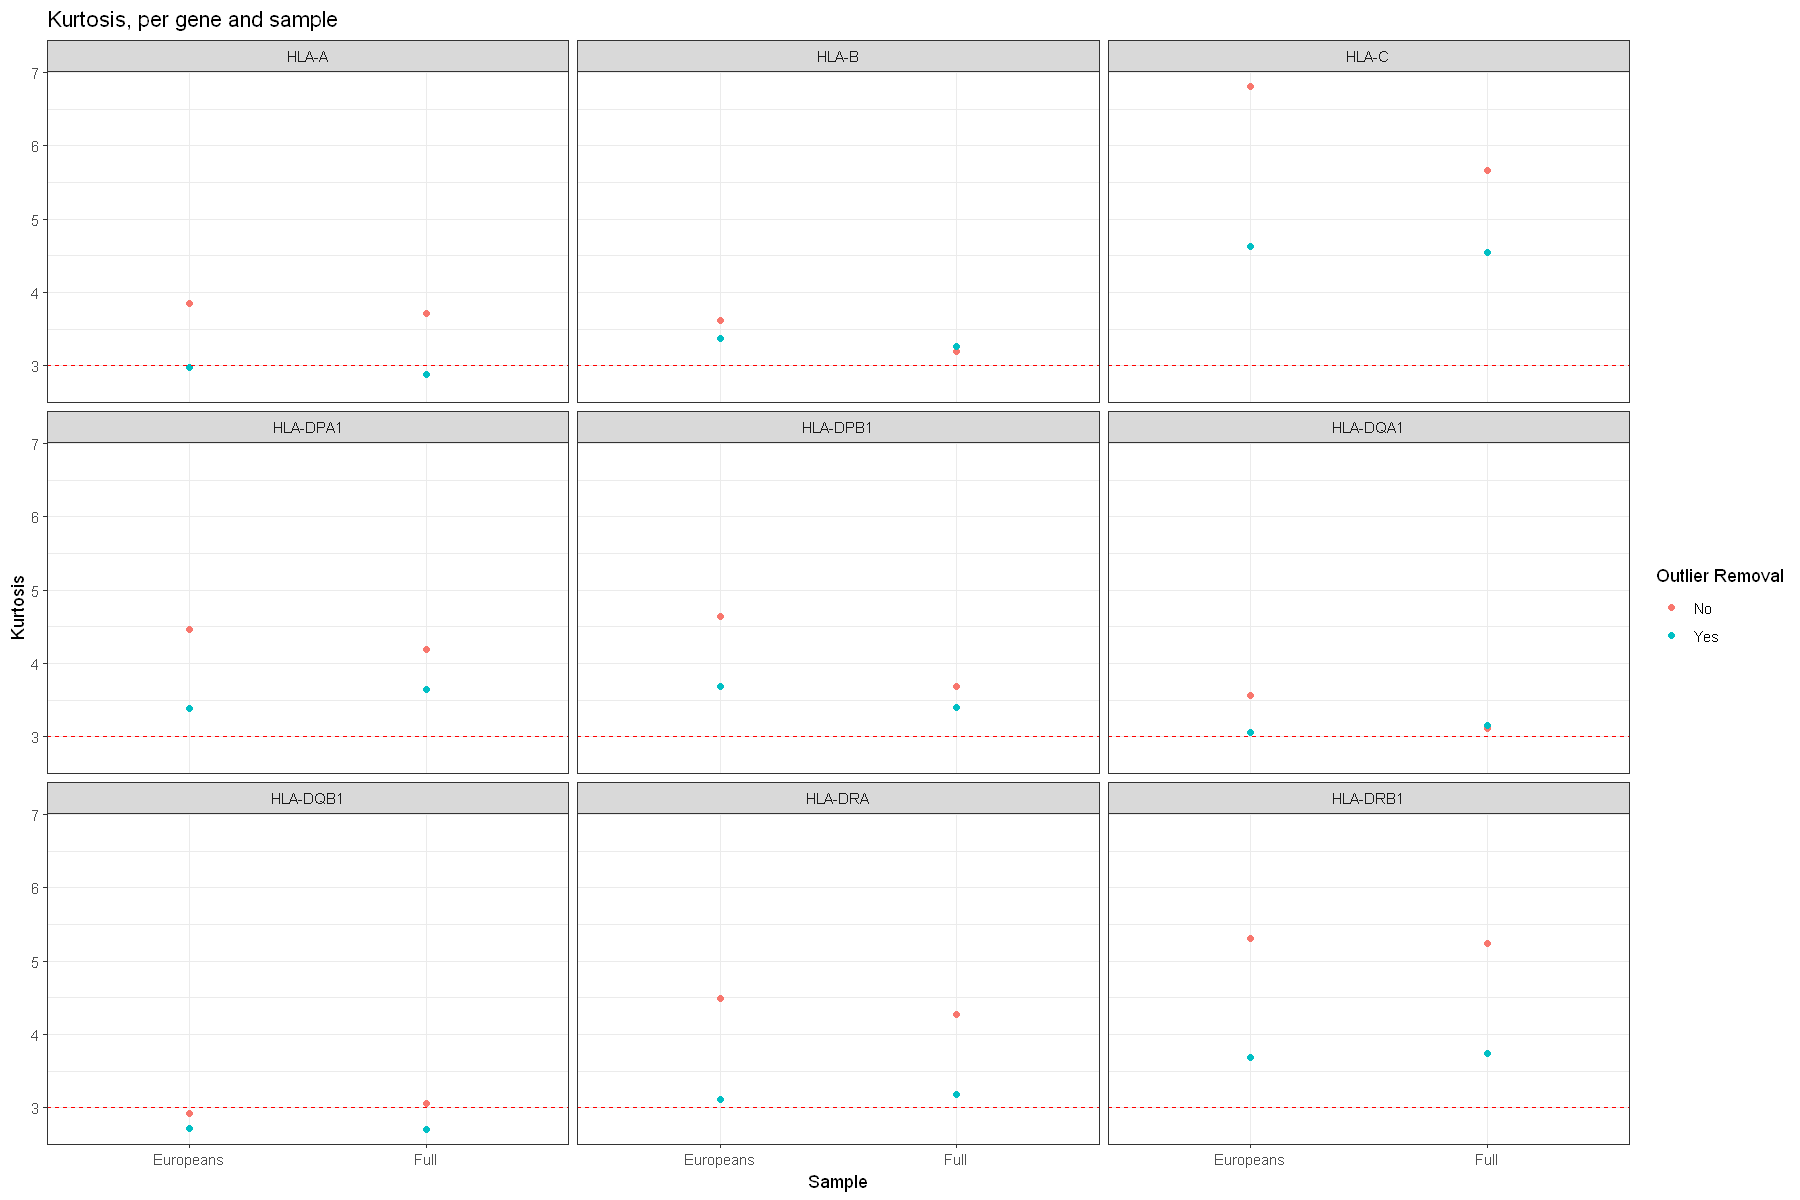

In [19]:
vars = c('KS', 'AD', 'Skewness', 'Kurtosis')
for(var_ in vars){
    plt_ = normalComparisonDf  %>% 
    mutate(removal = ifelse(grepl('Out',Sample) , 'Yes', 'No') , samp_ = ifelse(grepl('Eur',Sample) , 'Europeans', 'Full')) %>% 
    ggplot() +
    geom_point(aes(x = samp_ , y = get(var_), colour = removal)) +
    facet_wrap(~Gene, scale = 'fixed') +
    theme_bw() +
    labs(x = 'Sample', colour = 'Outlier Removal')
    if(var_ %in% c('KS','AD')){
        plt_ = plt_ + 
        labs(title = paste0("P-value for ", var_, ' metric, per gene and sample'), y = paste0(var_, ": P-value")) +
        geom_hline(yintercept = .05, linetype = 2, colour = 'red') + 
        scale_y_continuous(labels = percent_format(), limits=c(0,1))
    } else{
        plt_ = plt_ + 
        labs(title = paste0(var_, ', per gene and sample'), y = var_)
        if(var_ == 'Skewness'){
         plt_ = plt_ +    
            geom_hline(yintercept = 1, linetype = 2, colour = 'red')
        } else{
         plt_ = plt_ +    
            geom_hline(yintercept = 3, linetype = 2, colour = 'red')
        }
        
    }
    print(plt_)
}